# Plotting IV and PV Curves

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.style.use('ggplot')

## Import PVShadeSim

To run a simulation import the **pvsim** method from PVShadeSim.

In [2]:
from pvshadesim import pvsim, utils

**pvsim** includes a **run** command to run the entire simulation. It automatically loads the in-built cell, module, and shade databases, along with a sample simulation configuration file.

The command outputs a pandas dataframe that contains a summary of the results. Additionally, other files are created in the current working directory. 

In [3]:
cell_prm_csv = 'PVMM_cell_params_DB.csv'
mod_prm_csv = 'PVMM_mod_params_DB.csv'
shade_prm_csv = 'PVMM_shade_params_DB.csv'

sim_config_csv = 'Sim_Config.csv'

In [4]:
dfCases = pvsim.run(cell_prm_csv=cell_prm_csv, mod_prm_csv=mod_prm_csv, shade_prm_csv=shade_prm_csv,
                    sim_config_csv=sim_config_csv, save_detailed=True)

Time elapsed to generate Module Models: 0.43726015090942383 s
Time elapsed to generate Shade Scenarios: 5.232578992843628 s
Time elapsed to run default_half_TB: 30.84683632850647 s
Time elapsed: 35.88513708114624 s


## Load the detailed output data

In [5]:
detailed_dict = utils.load_pickle('Detailed_Data.pickle')

## Some plot examples

### Plot Irradiance arrays at module level for each unique module

This piece of code generates the unique cell-level irradiance on each module. The plots are stored in a PDF file in cwd.

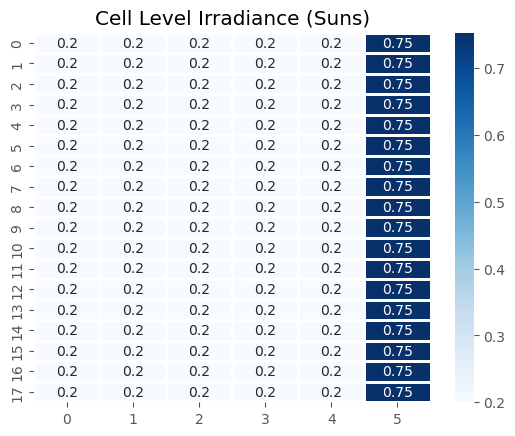

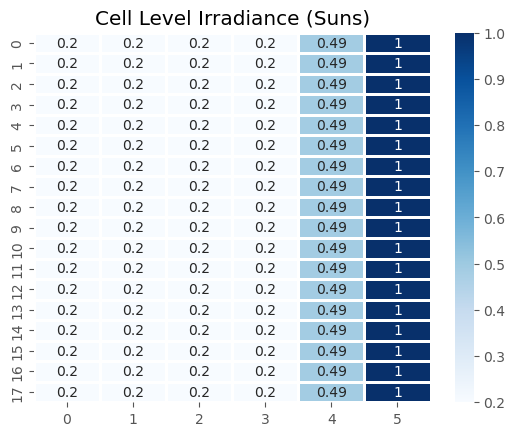

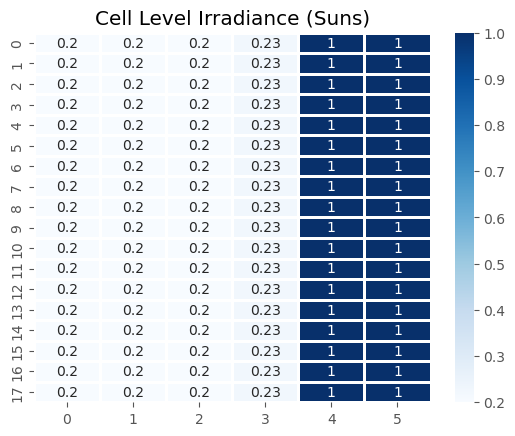

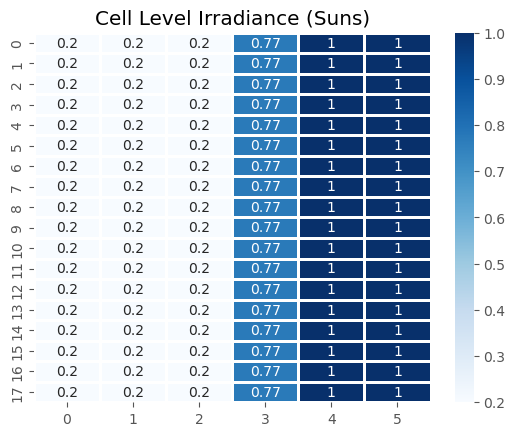

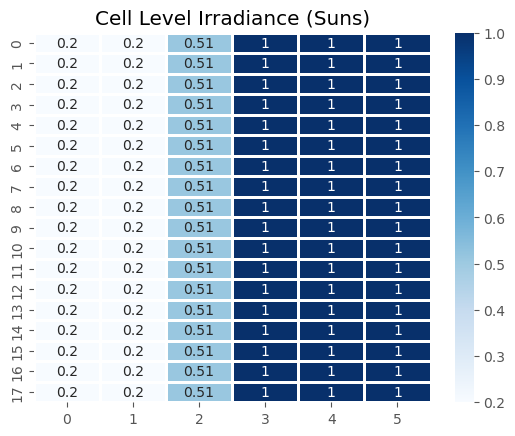

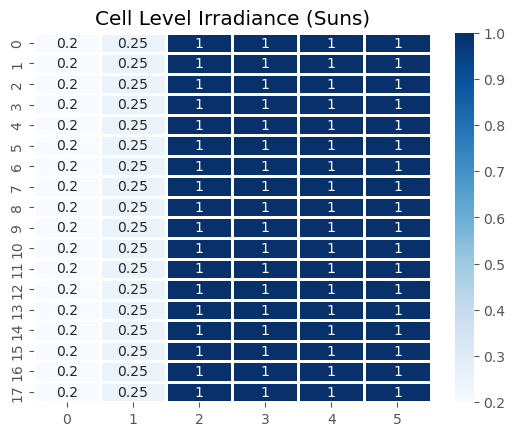

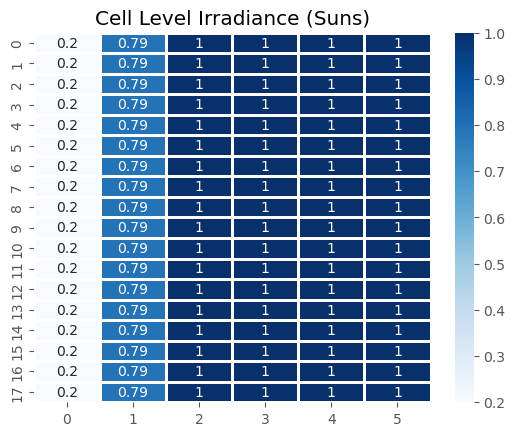

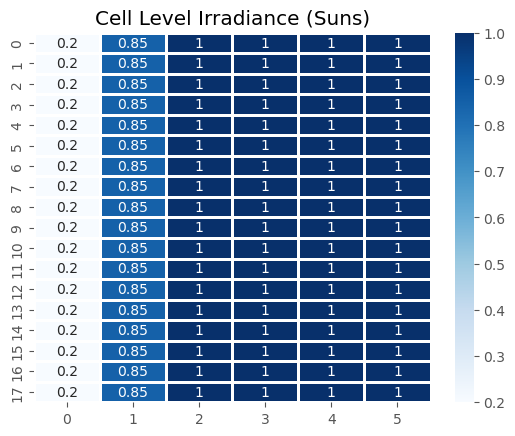

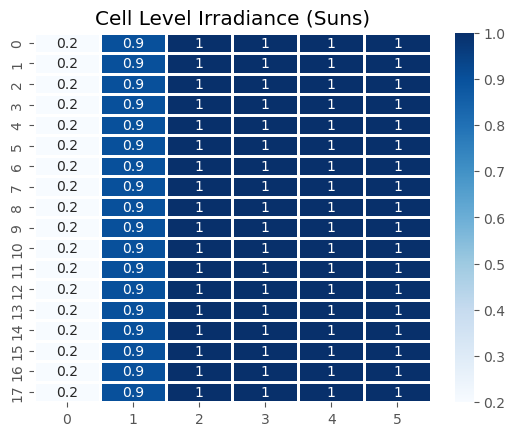

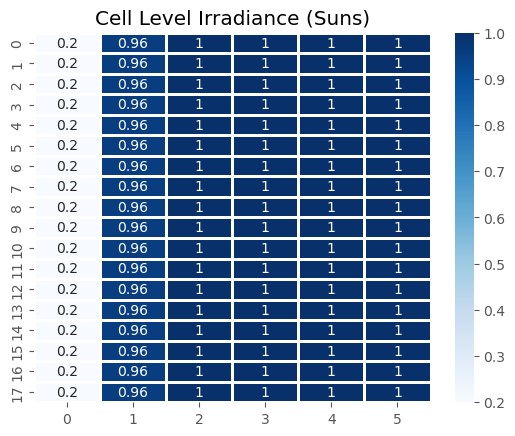

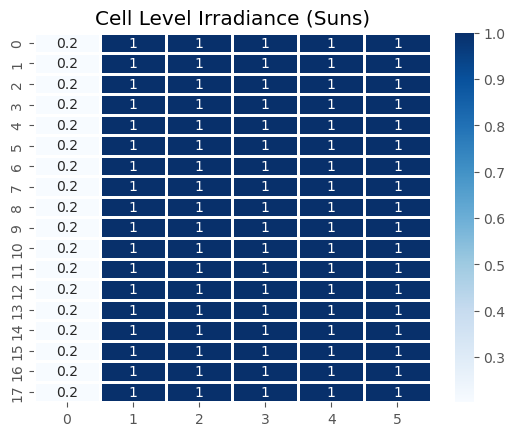

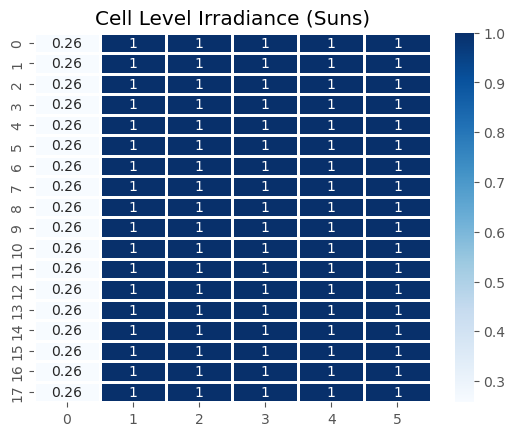

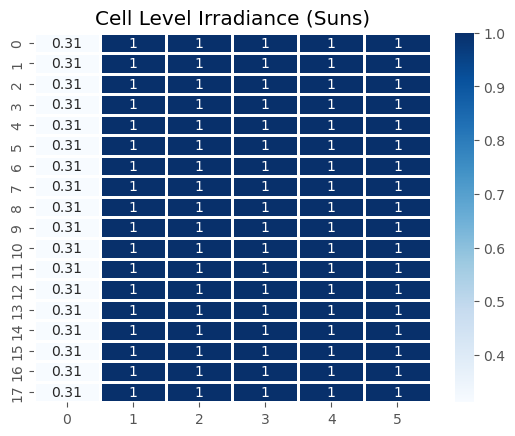

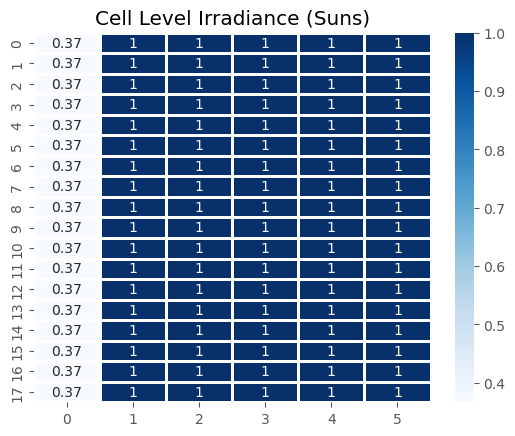

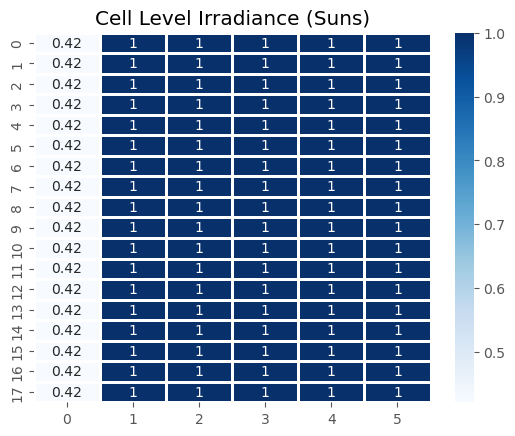

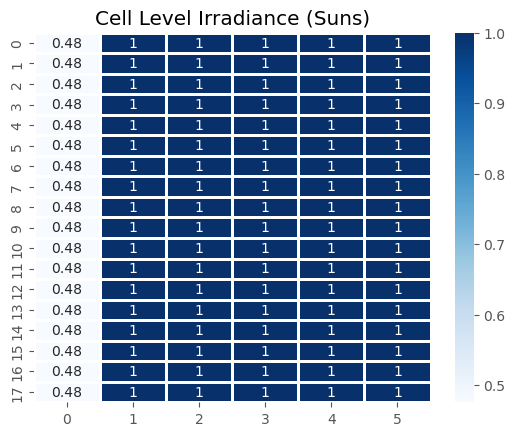

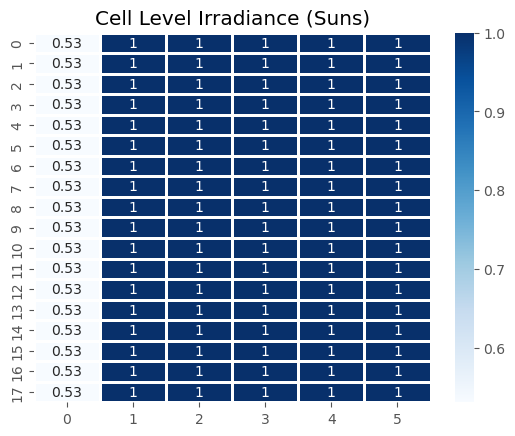

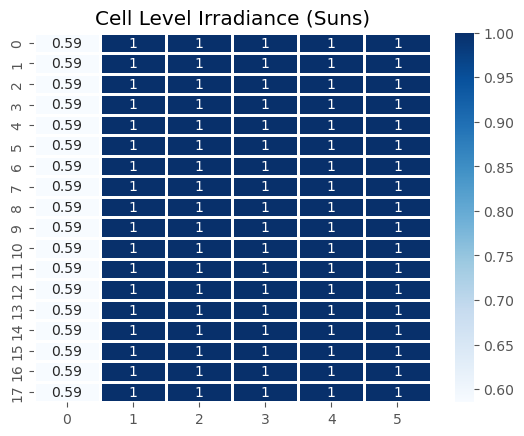

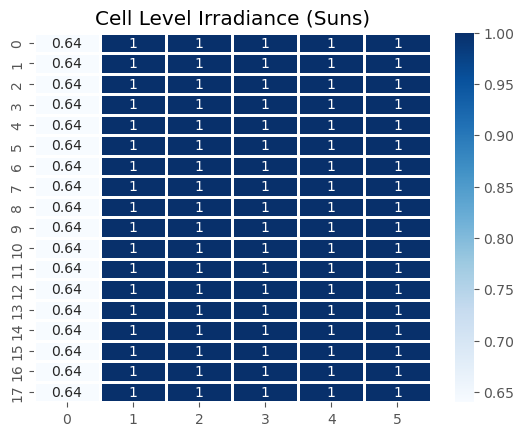

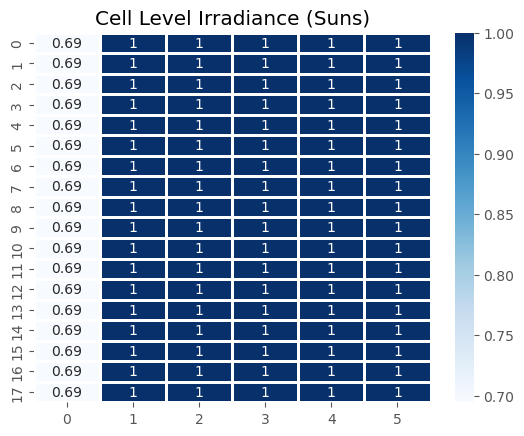

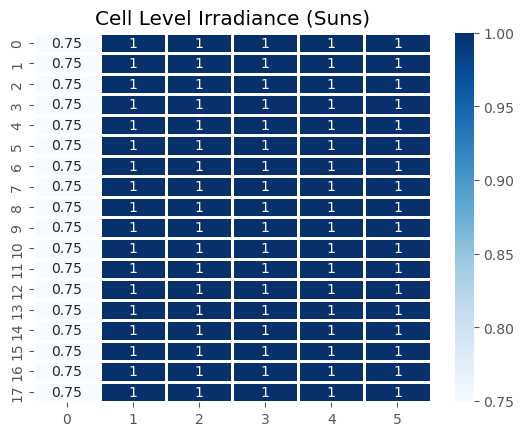

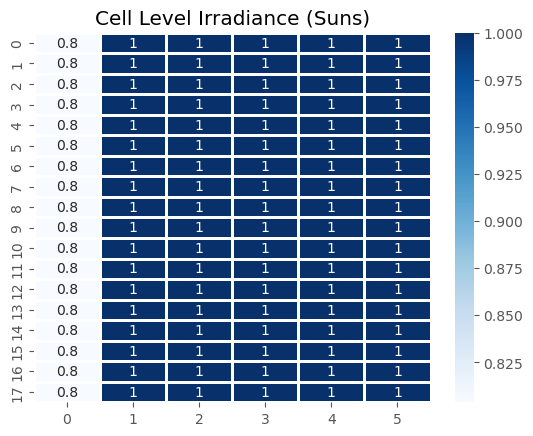

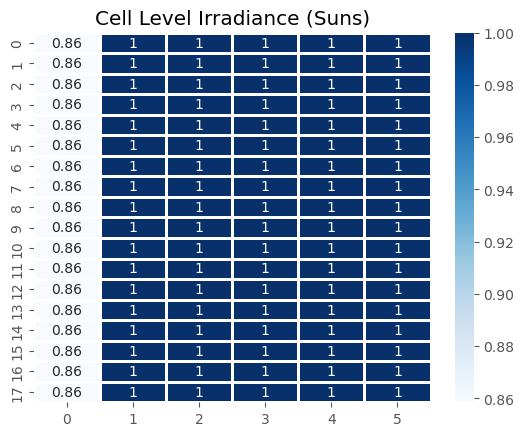

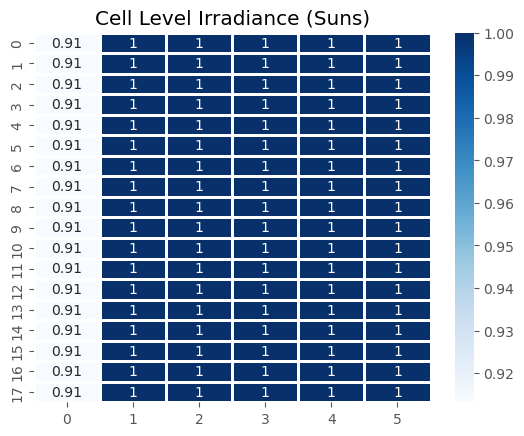

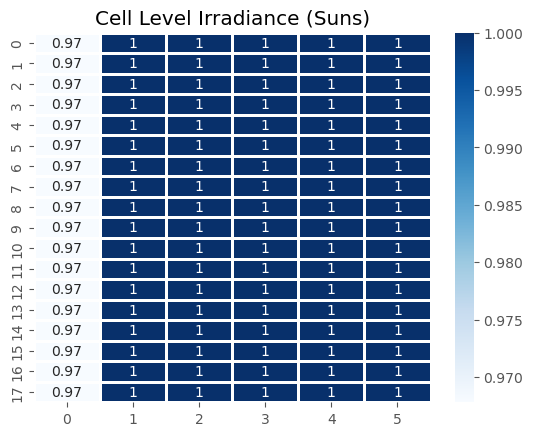

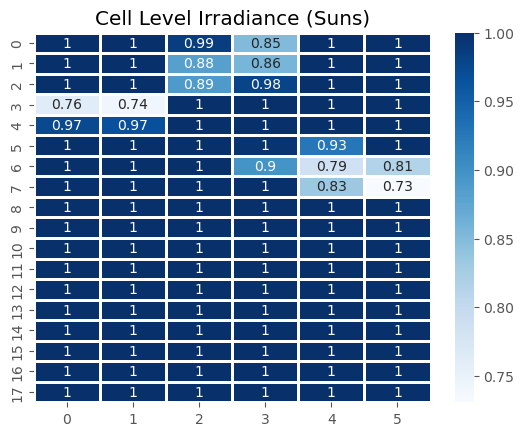

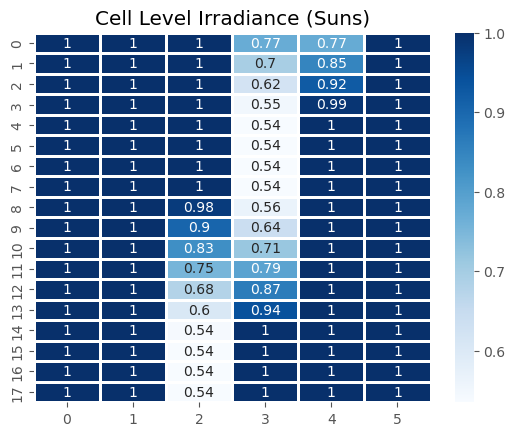

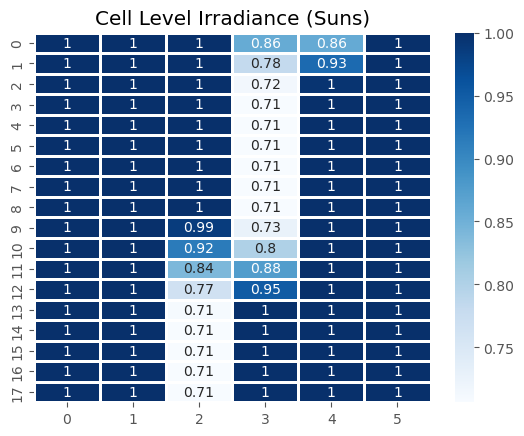

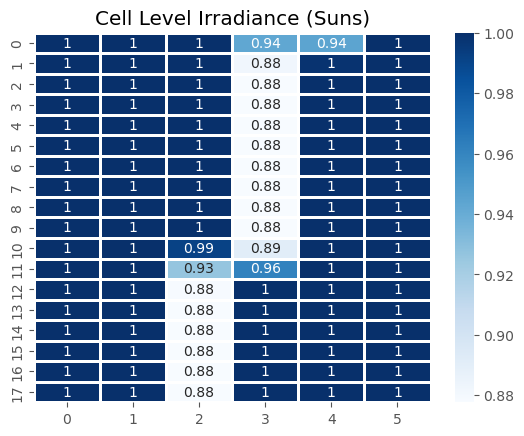

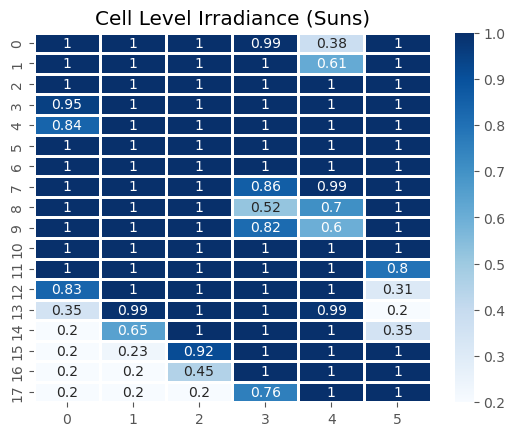

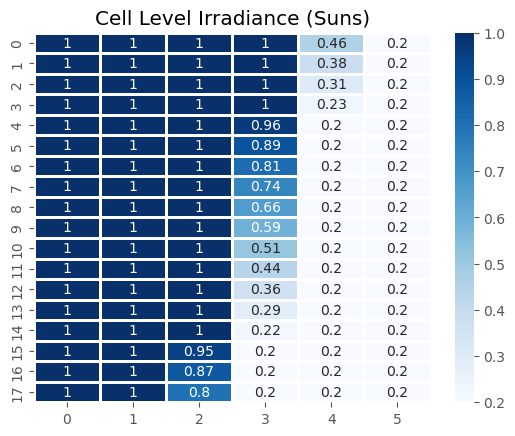

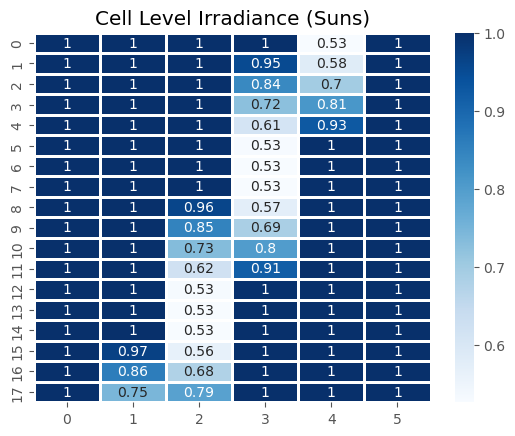

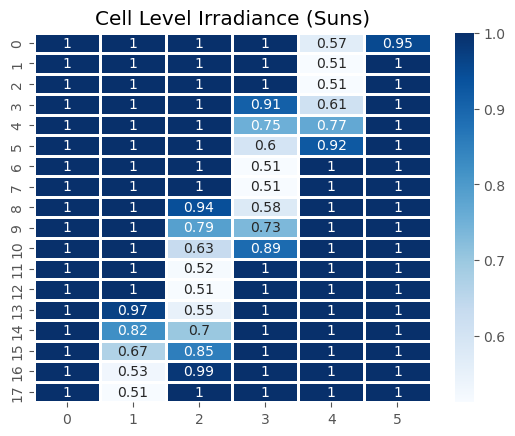

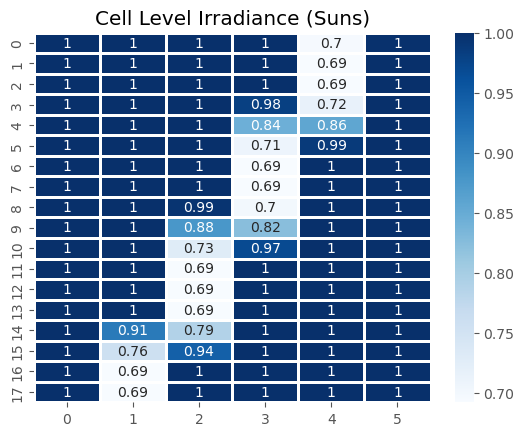

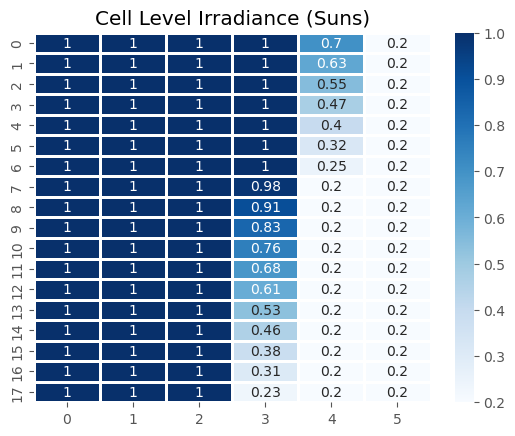

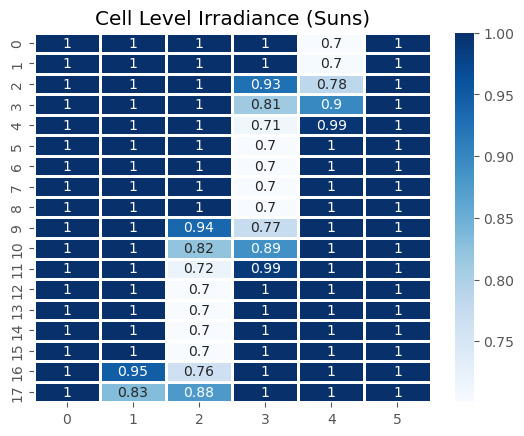

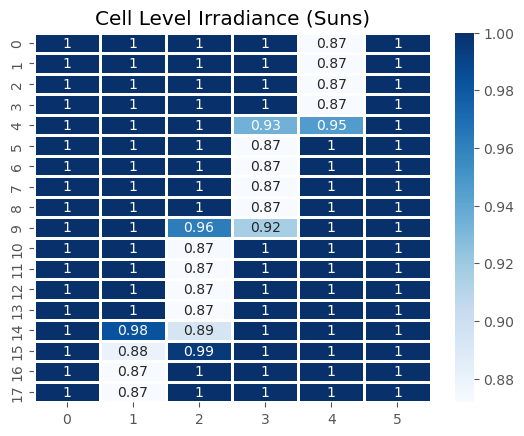

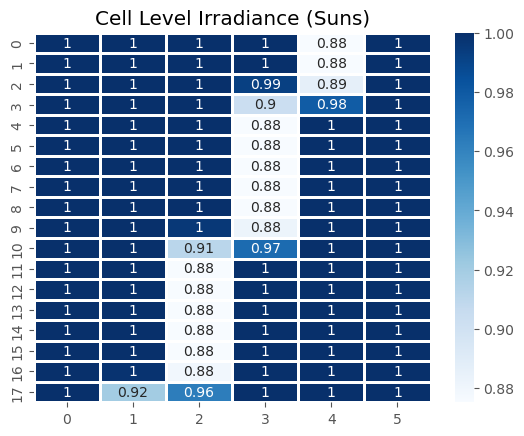

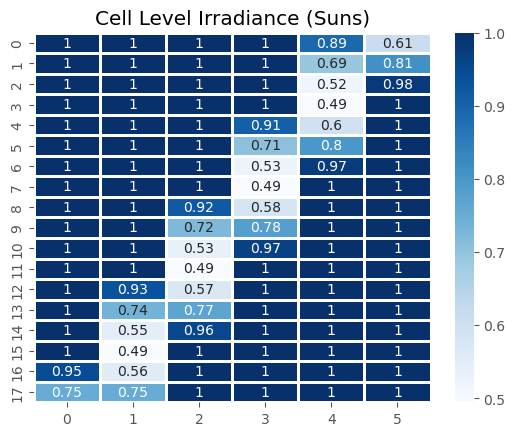

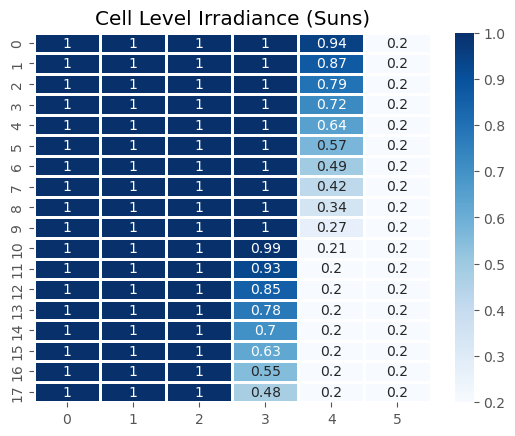

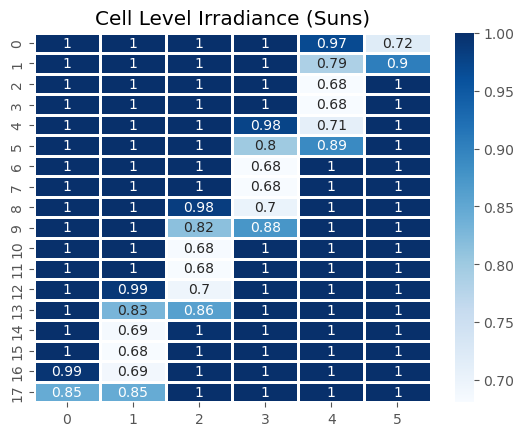

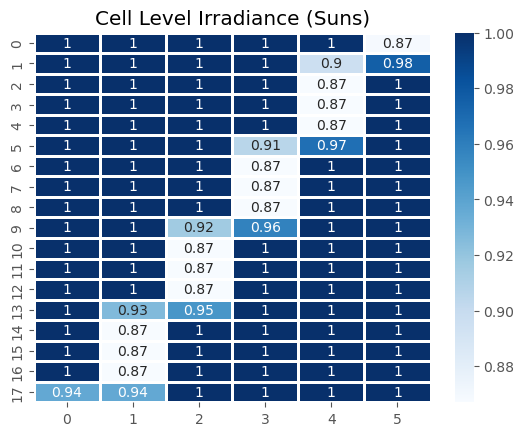

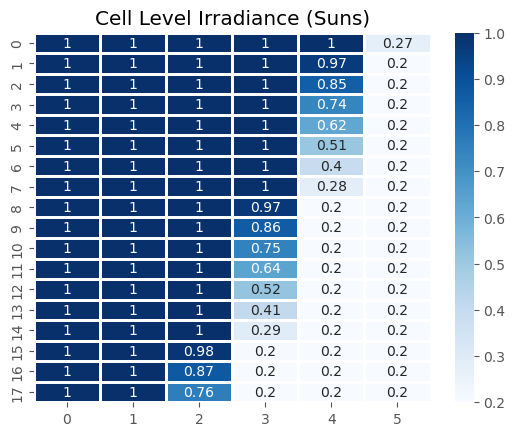

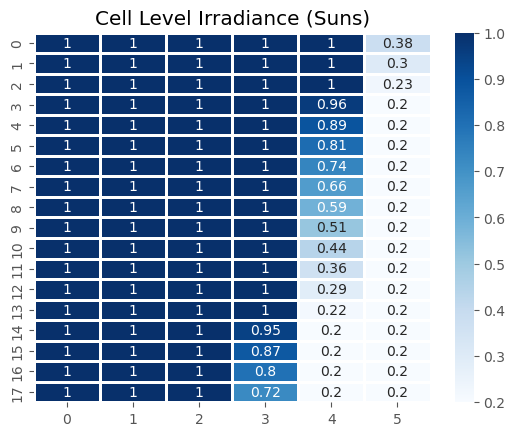

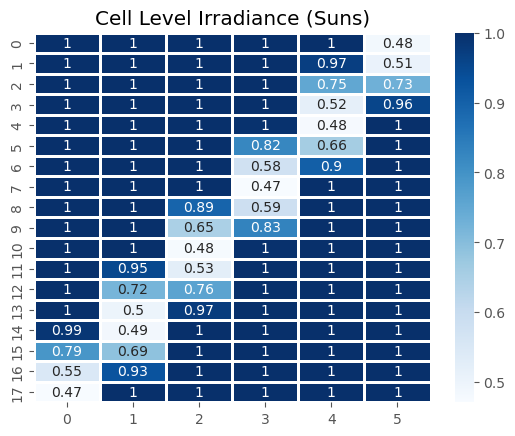

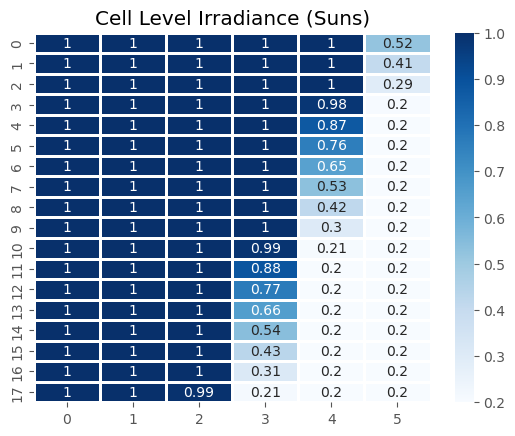

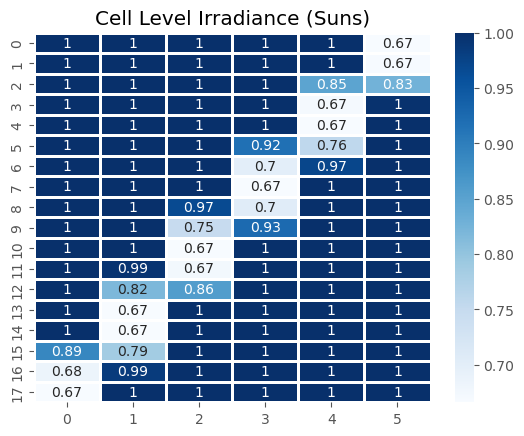

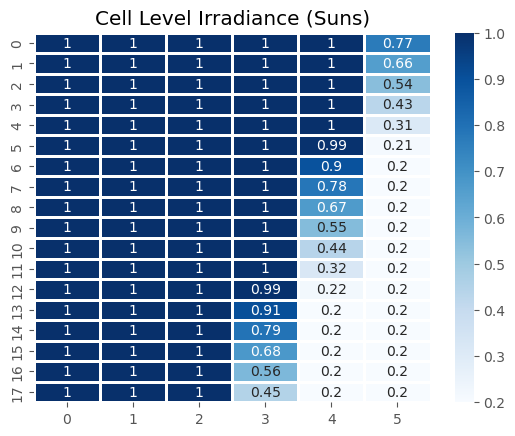

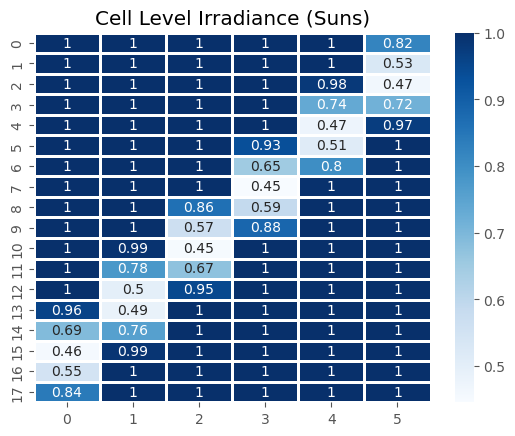

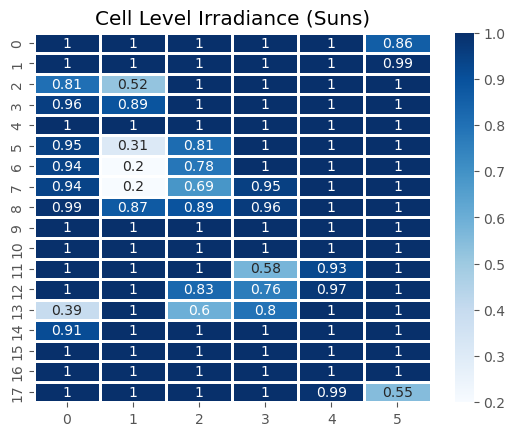

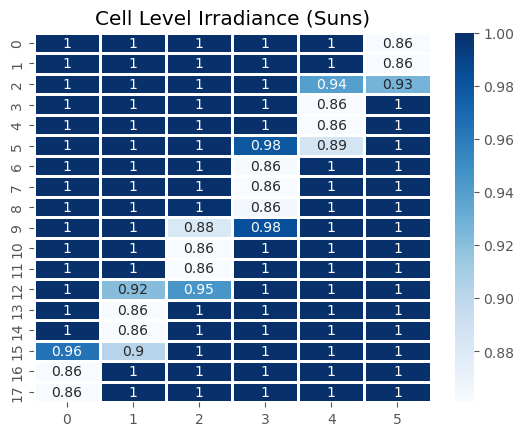

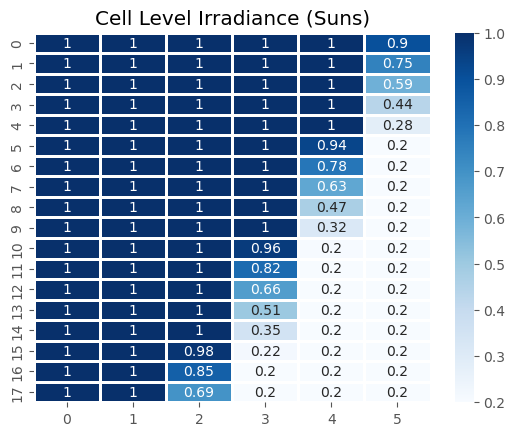

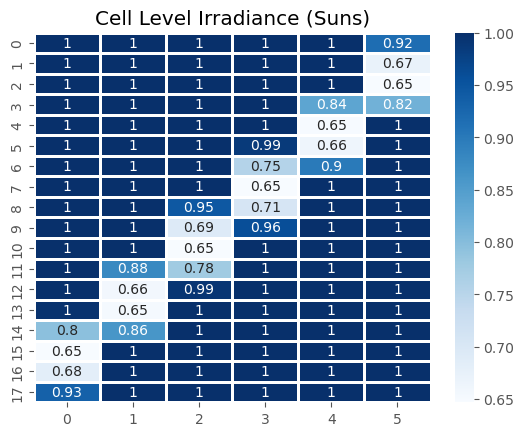

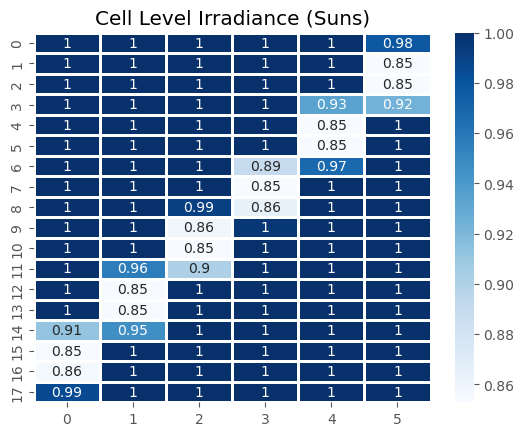

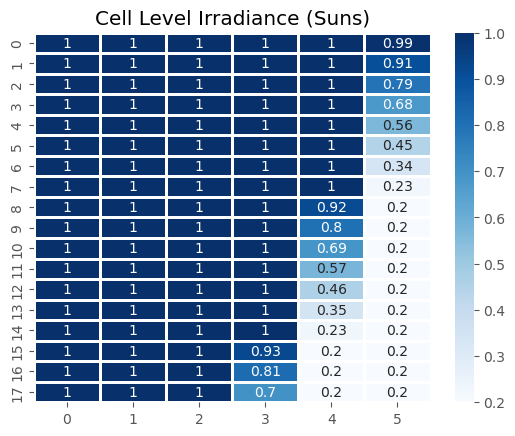

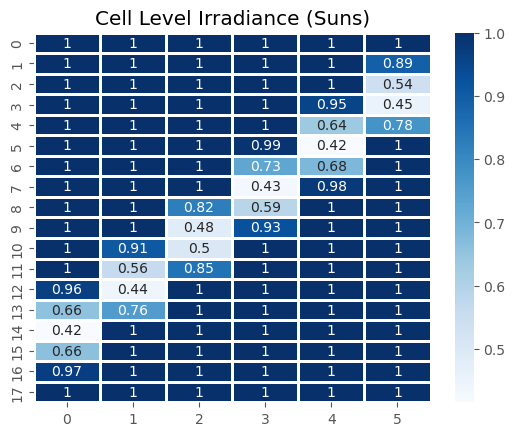

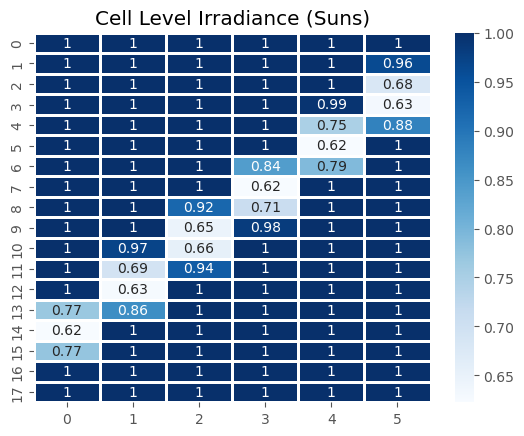

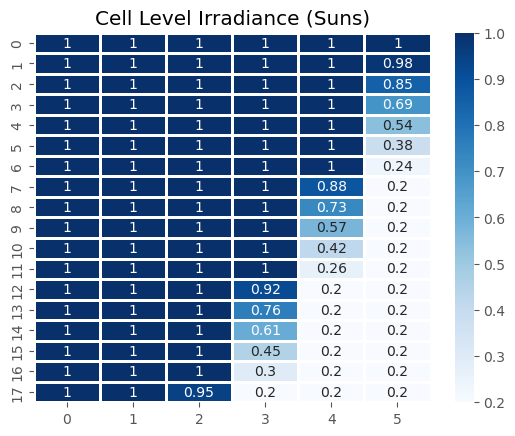

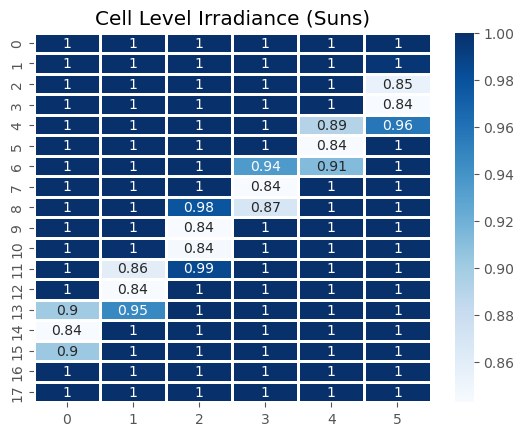

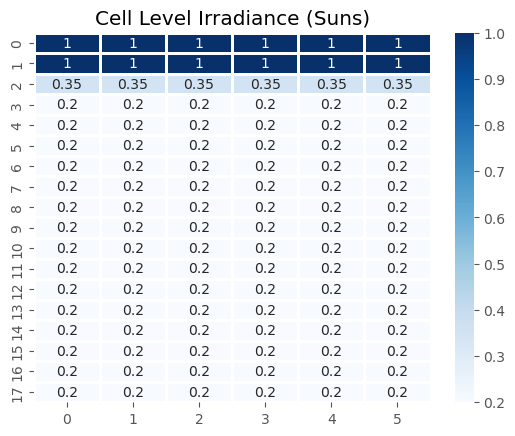

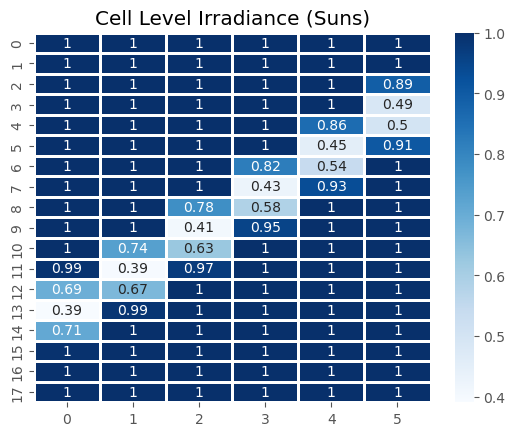

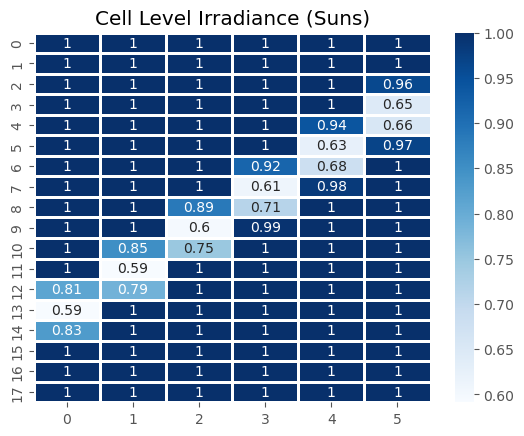

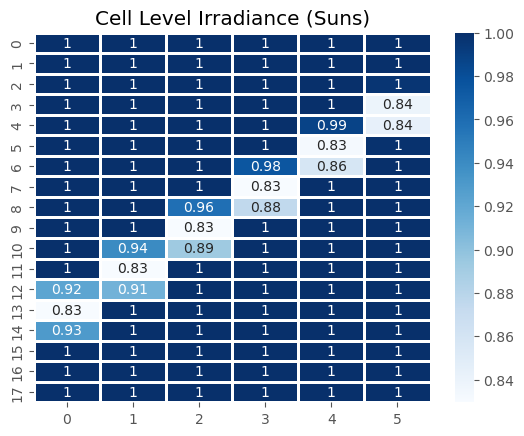

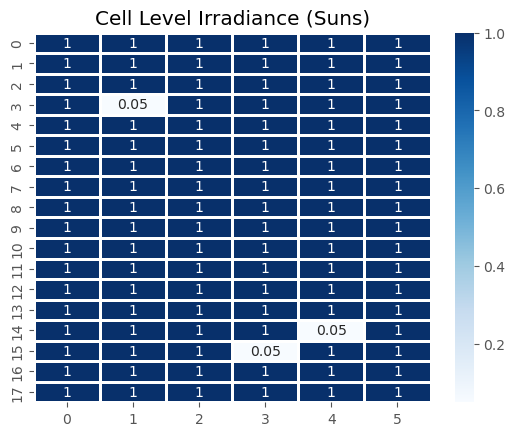

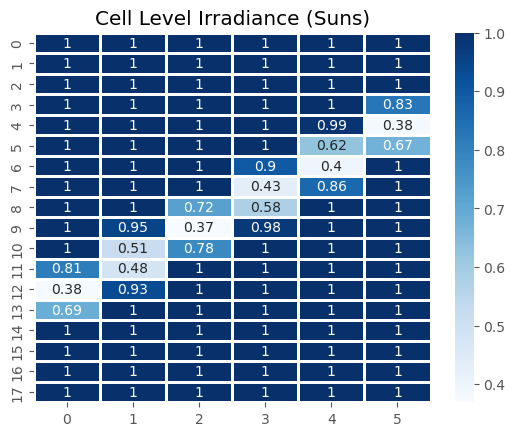

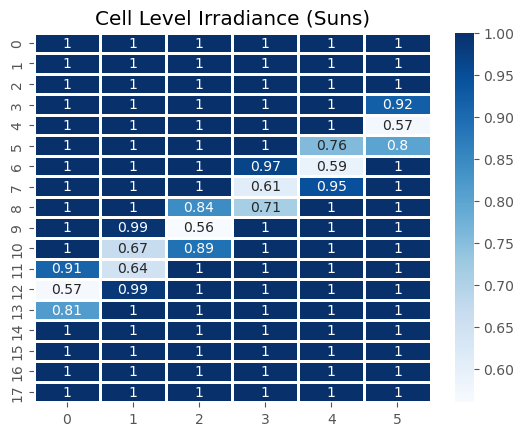

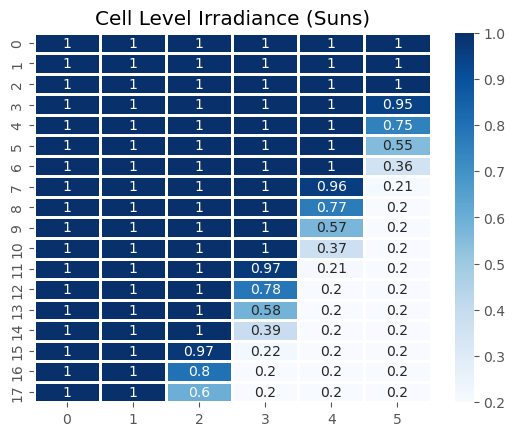

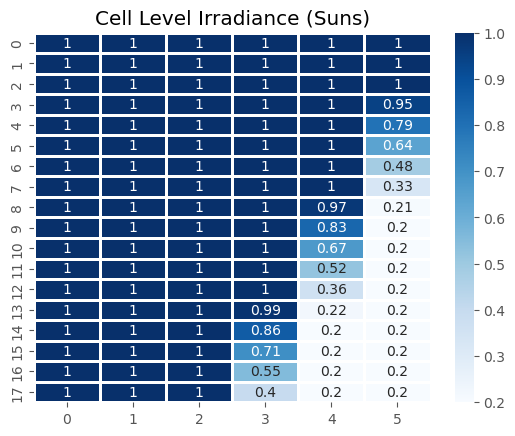

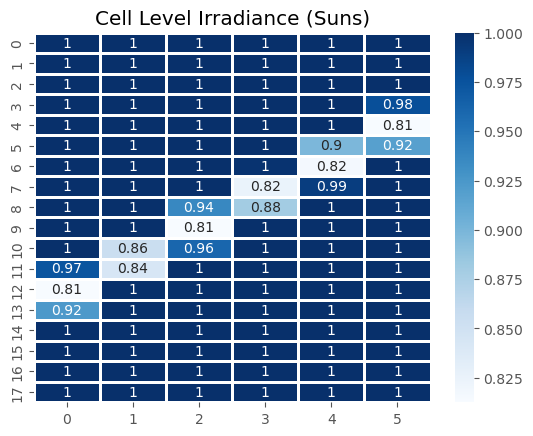

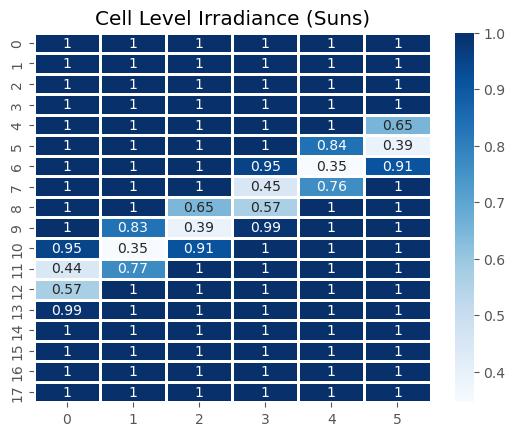

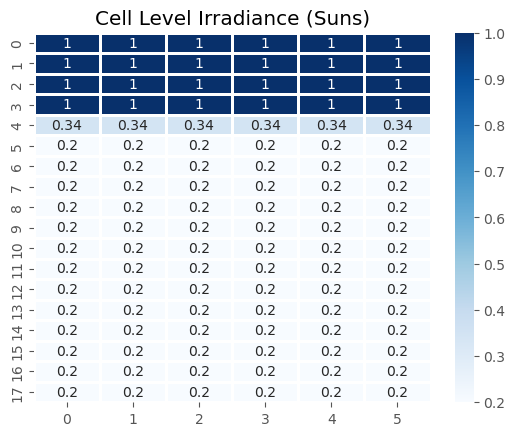

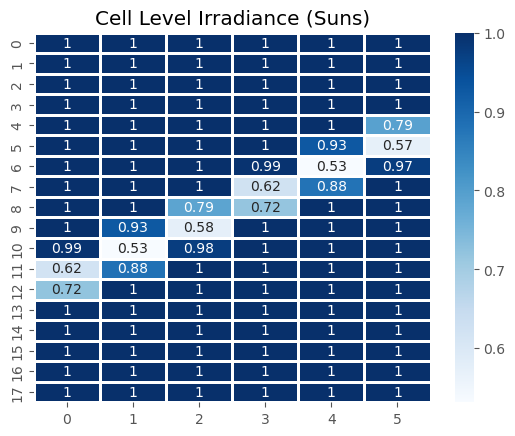

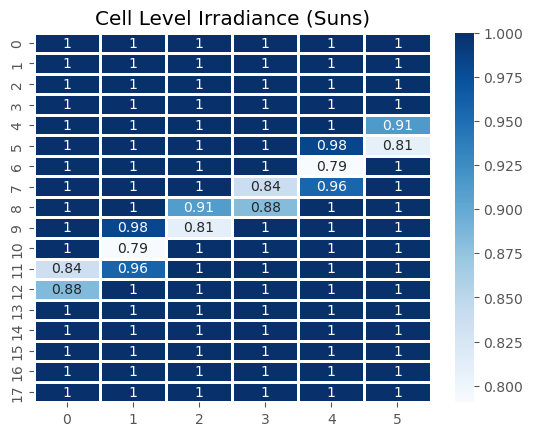

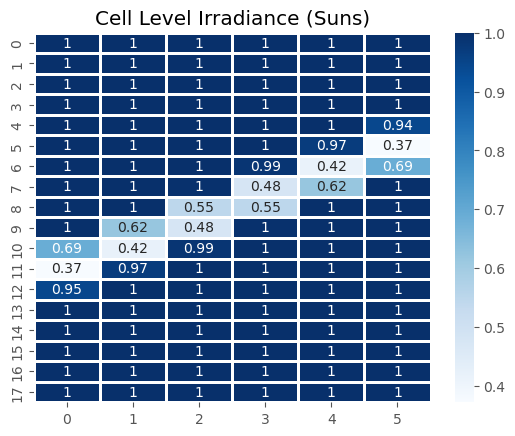

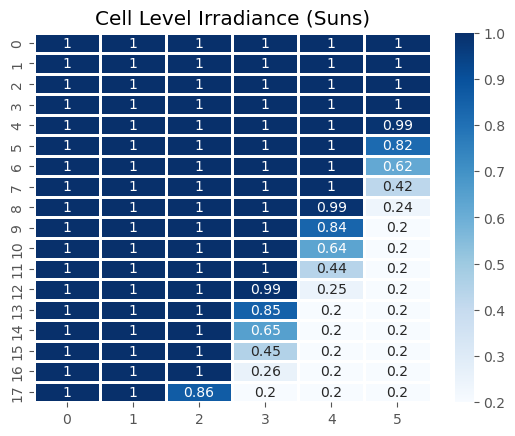

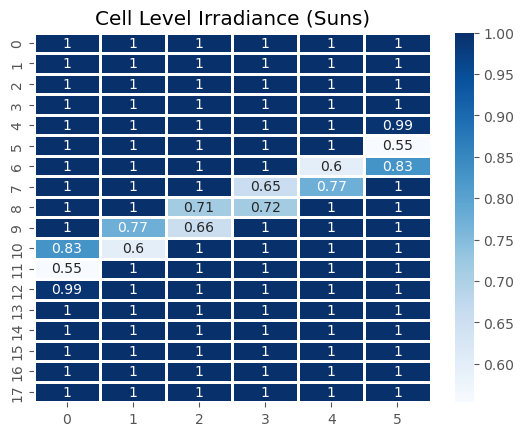

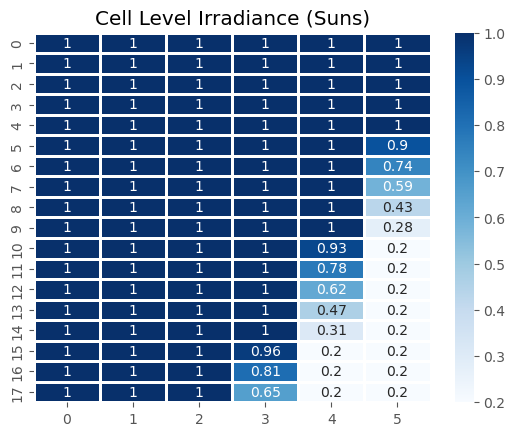

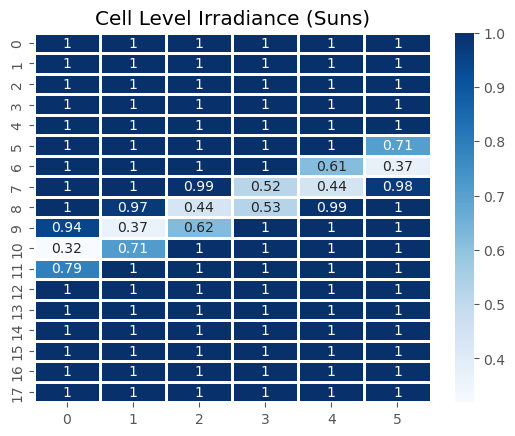

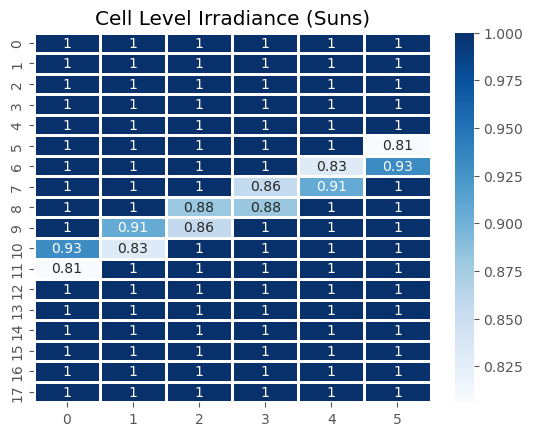

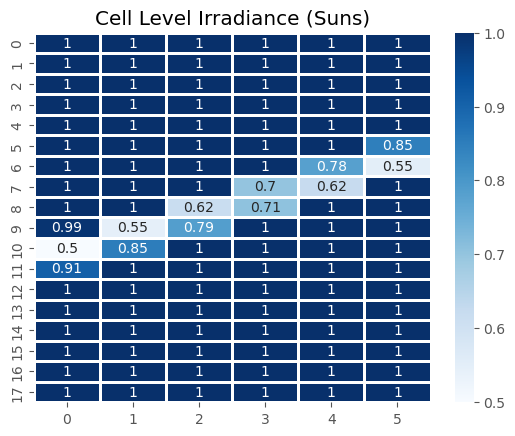

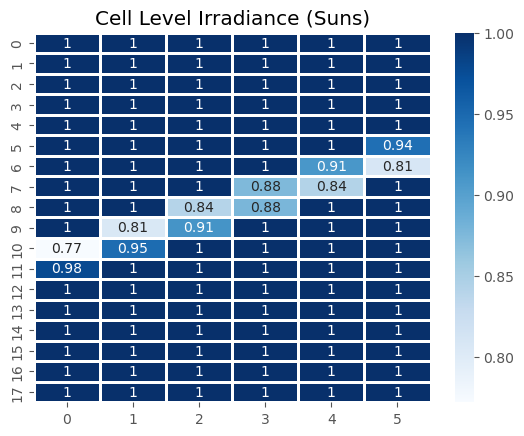

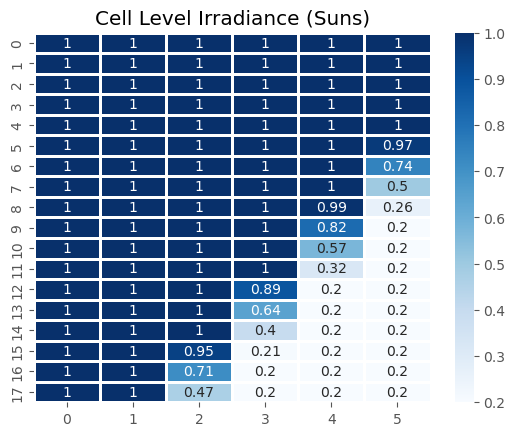

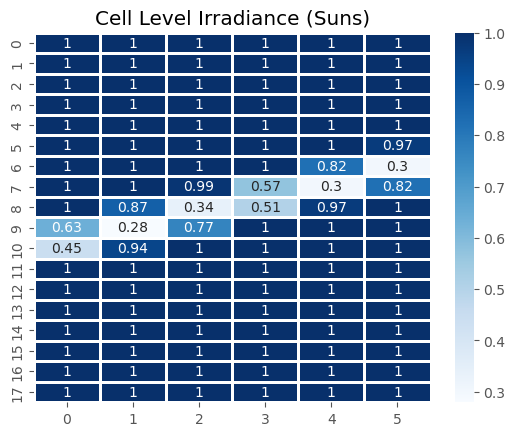

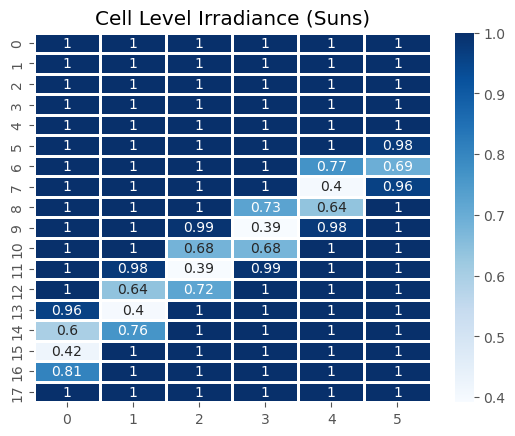

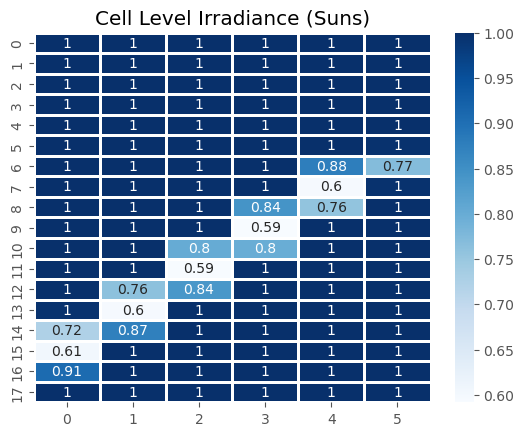

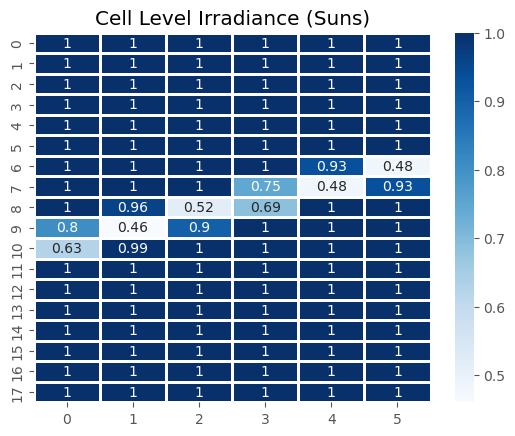

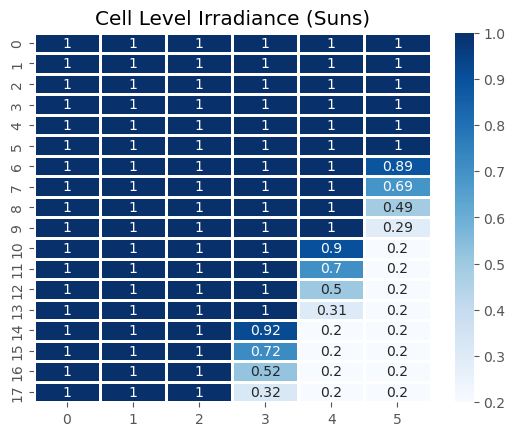

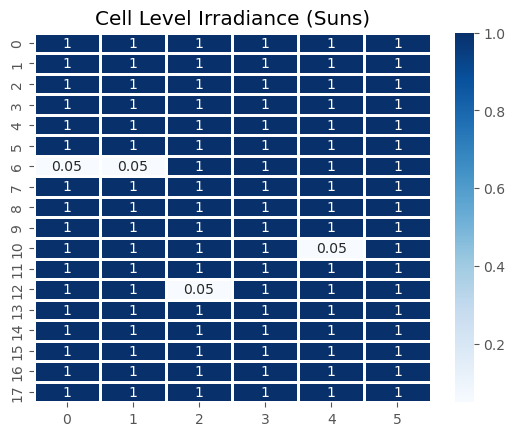

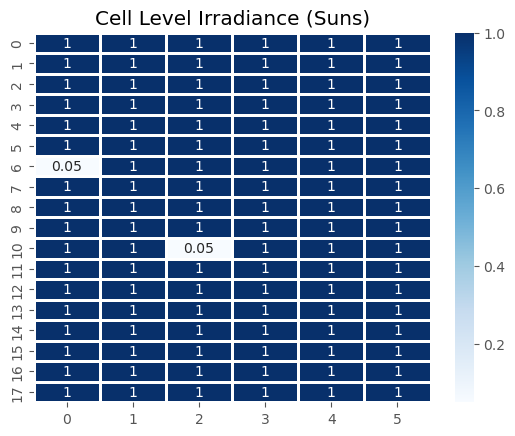

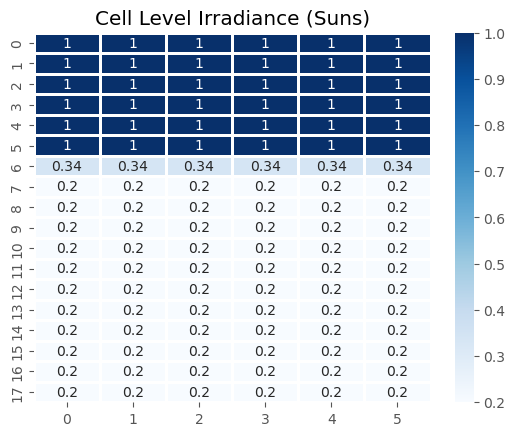

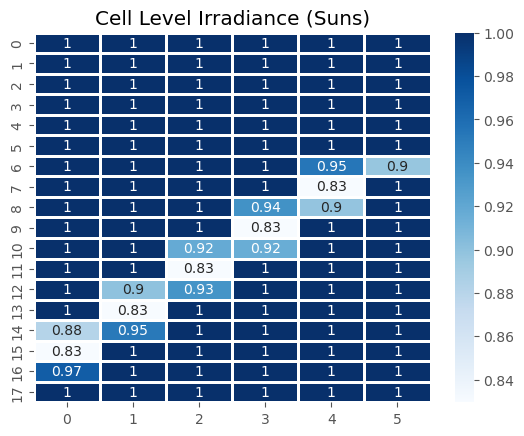

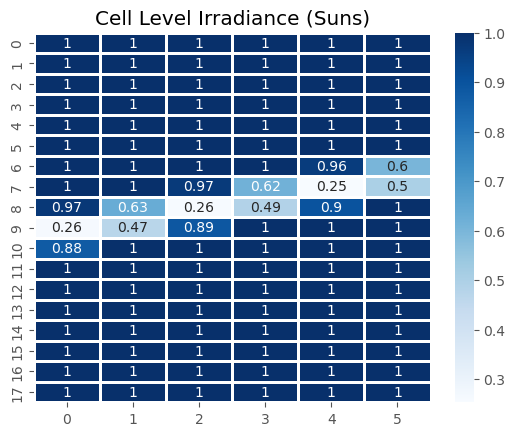

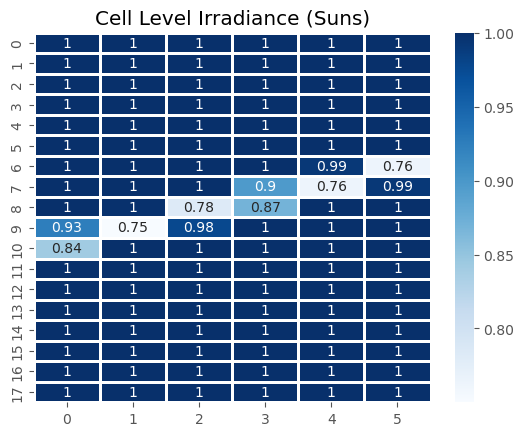

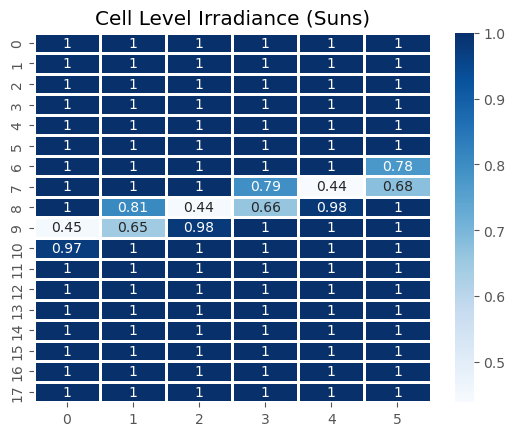

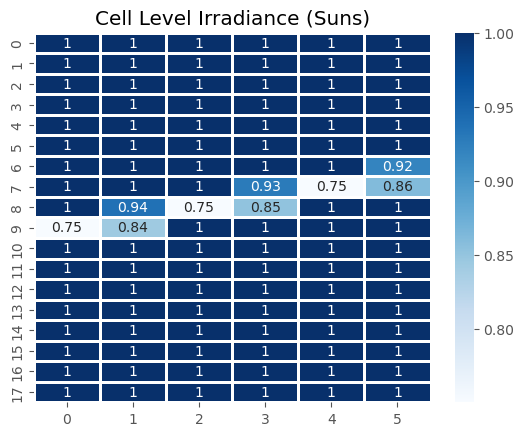

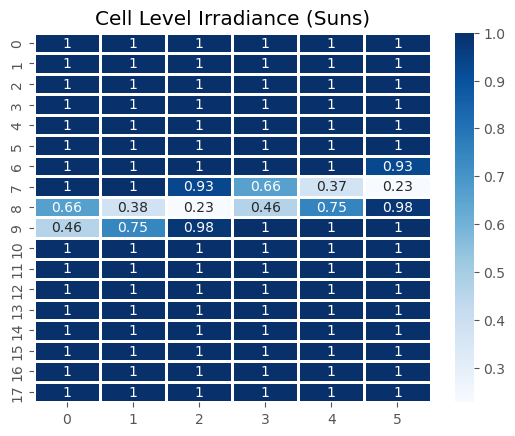

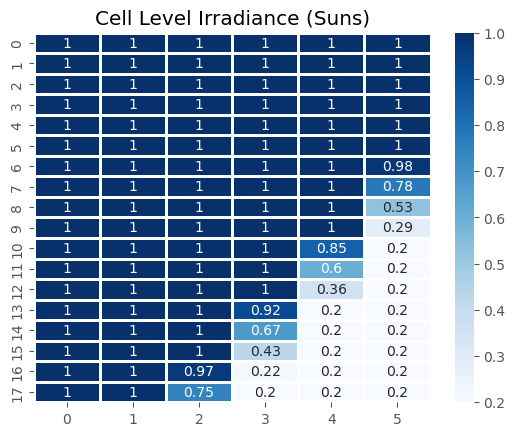

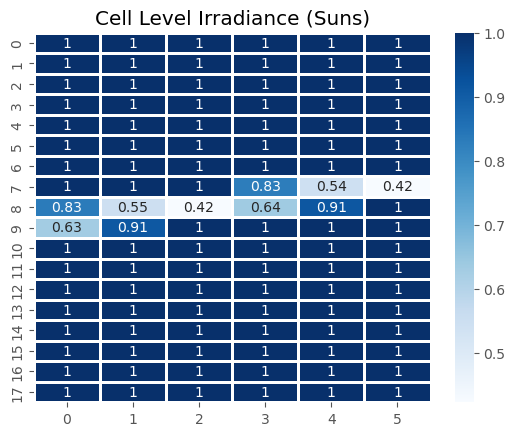

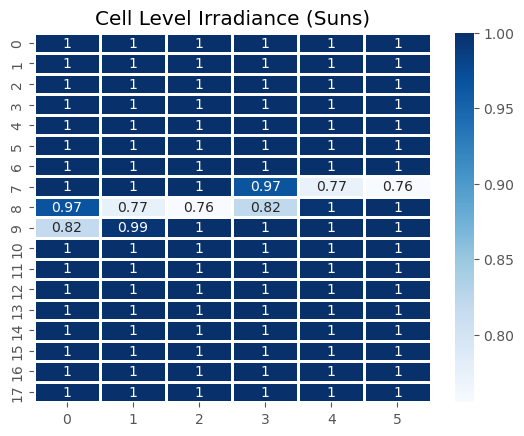

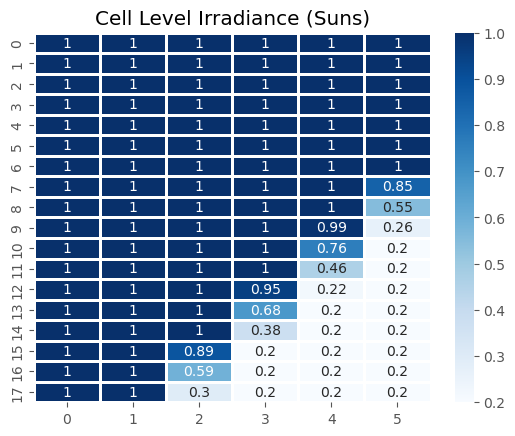

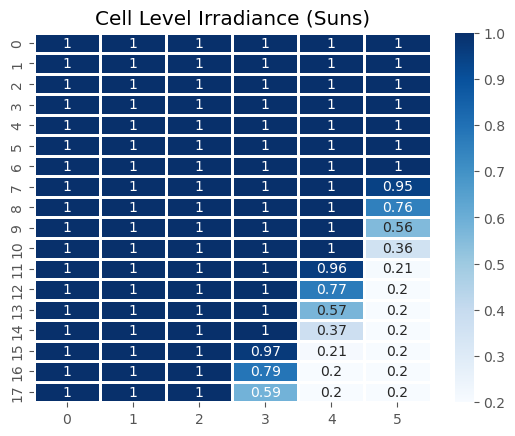

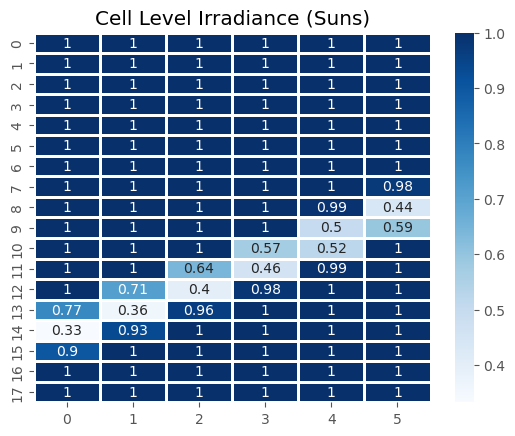

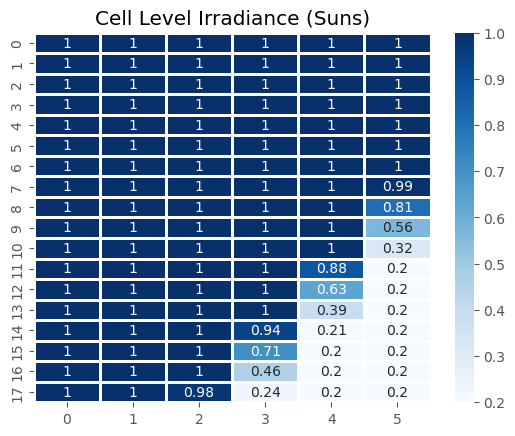

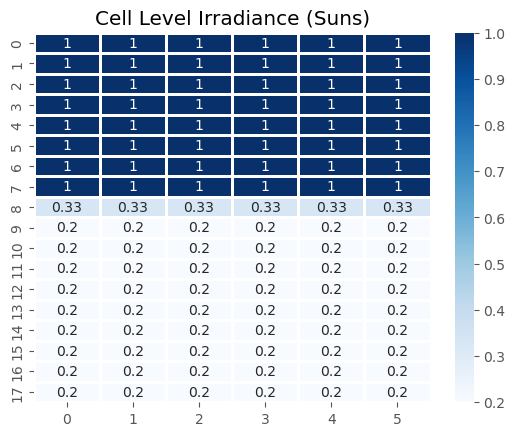

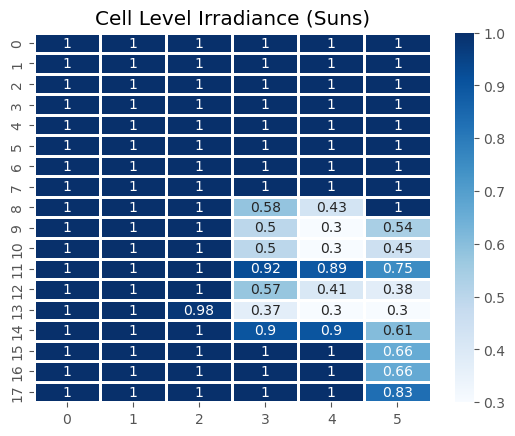

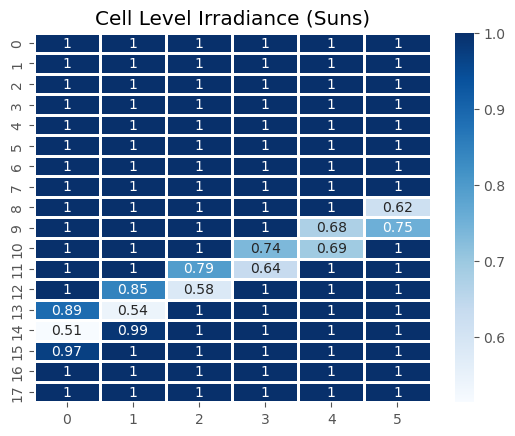

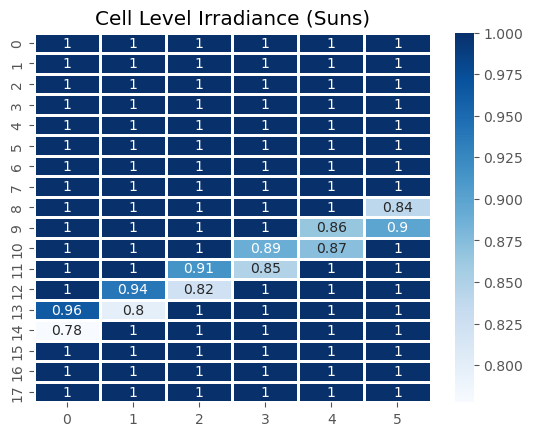

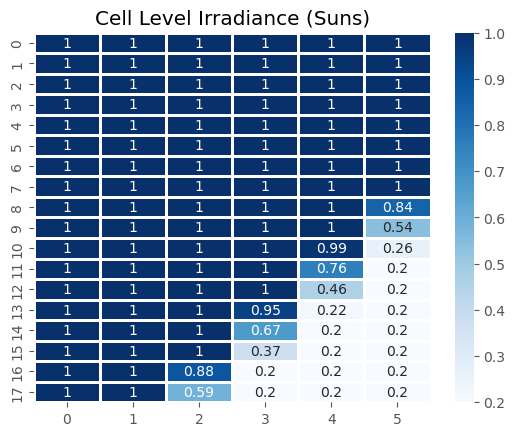

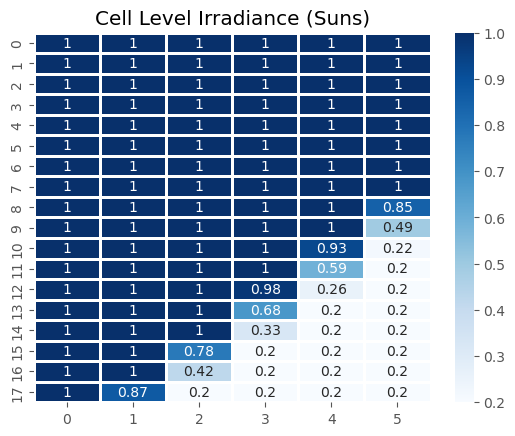

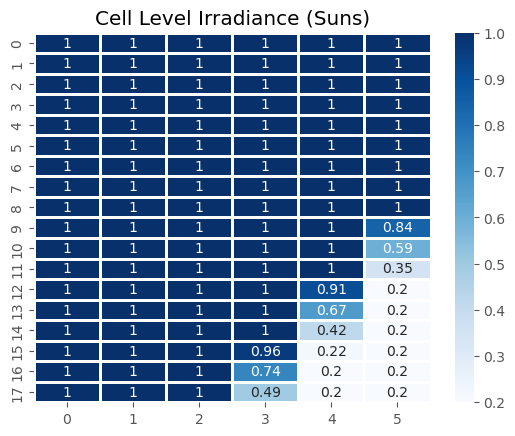

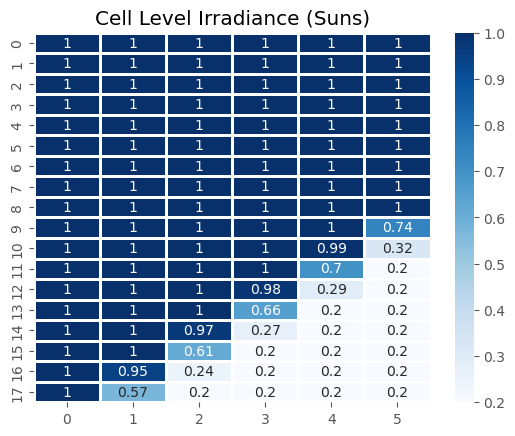

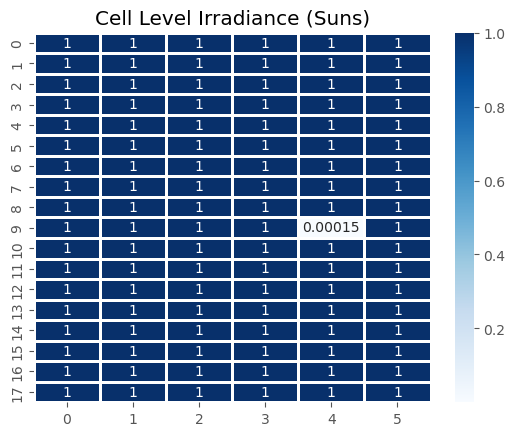

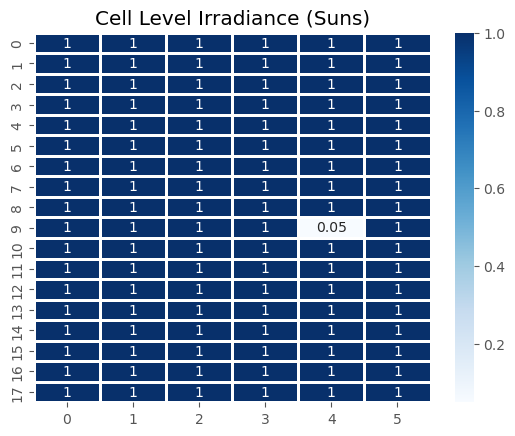

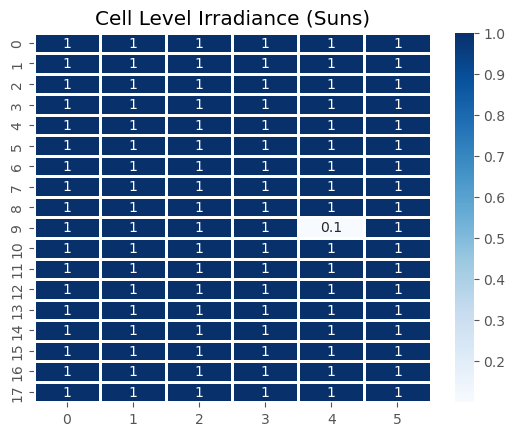

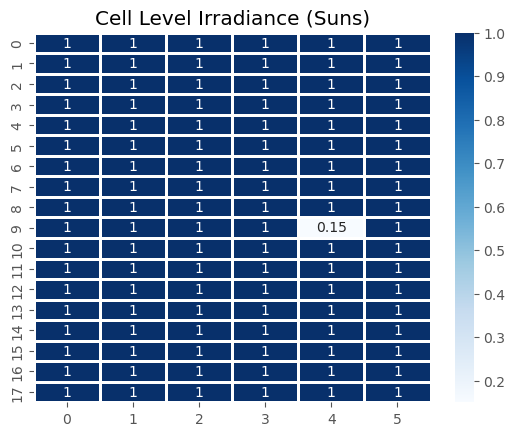

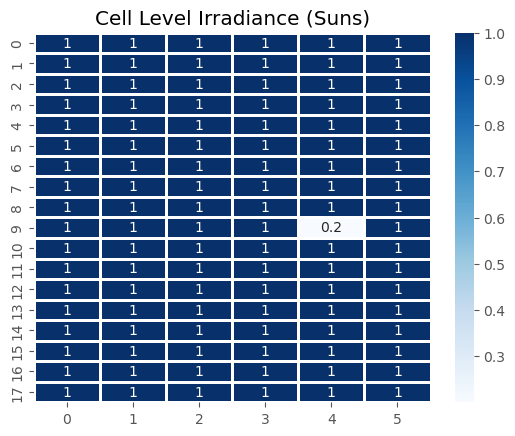

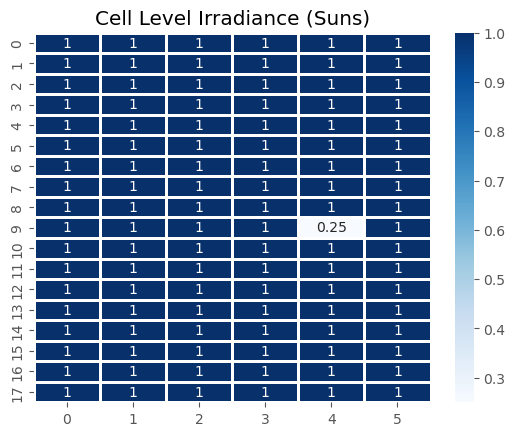

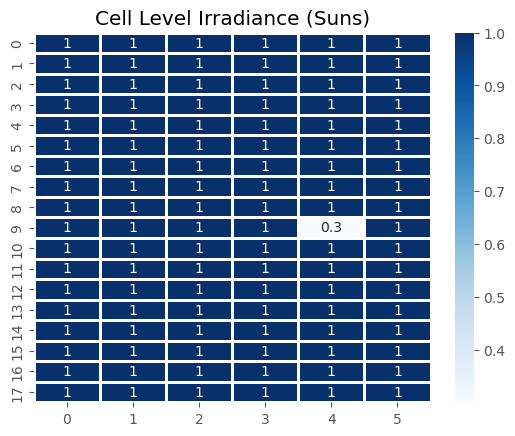

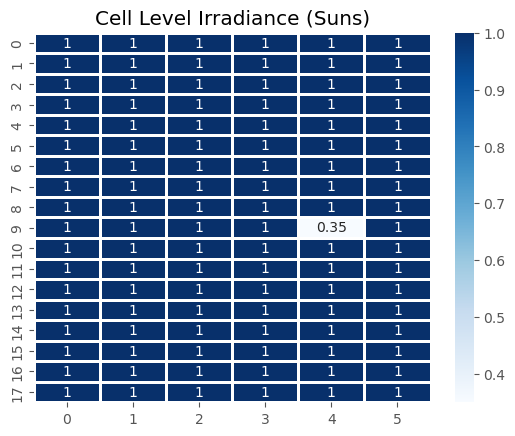

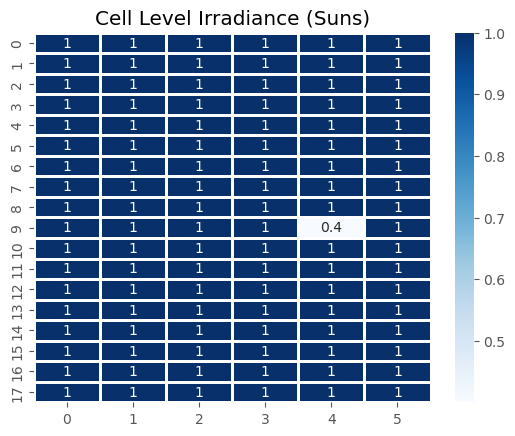

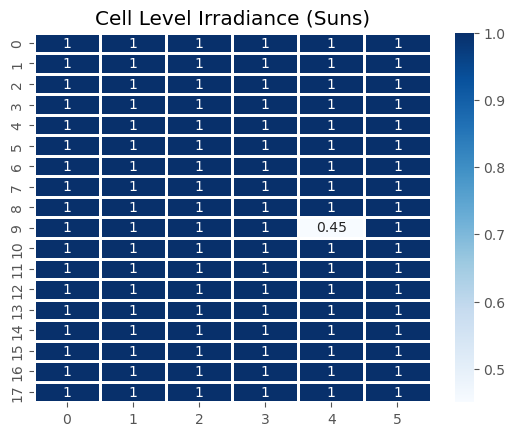

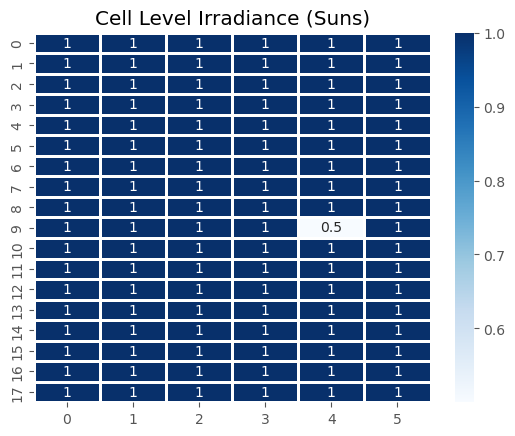

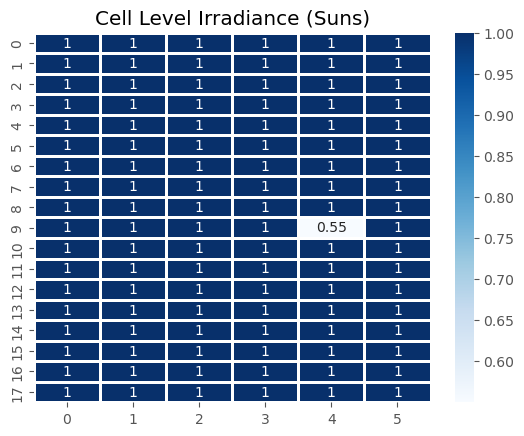

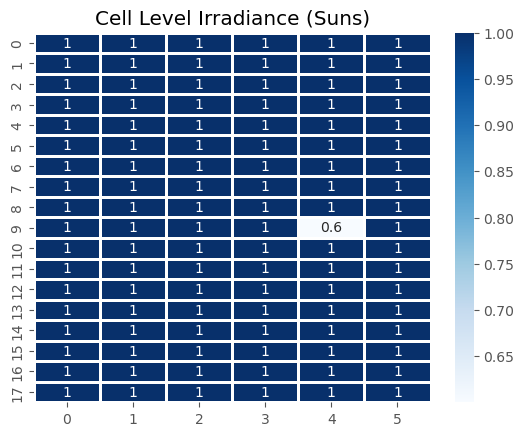

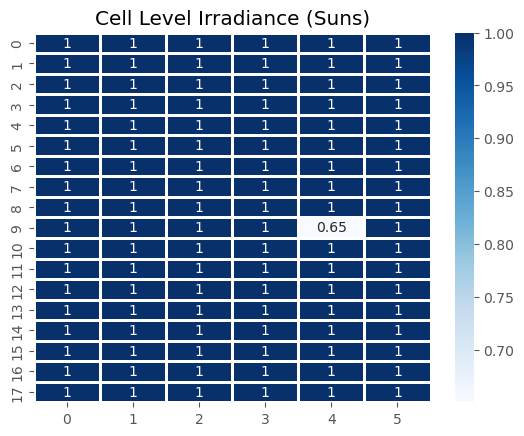

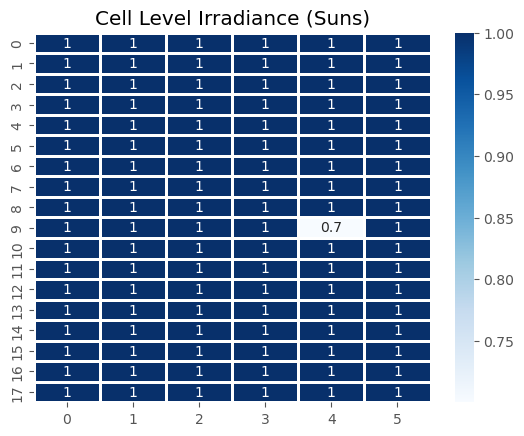

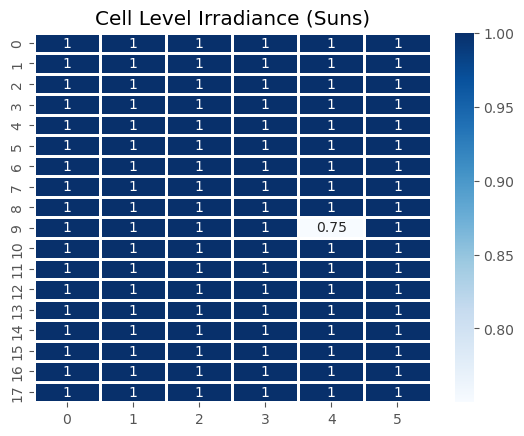

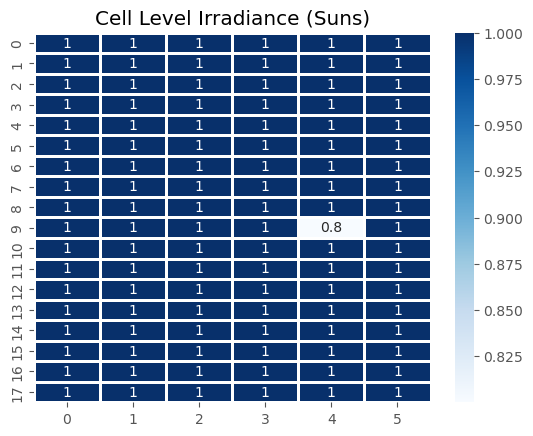

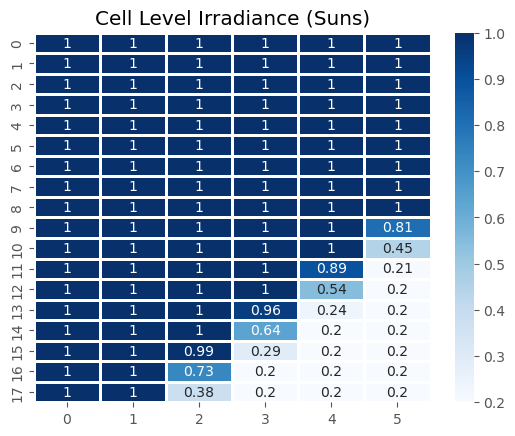

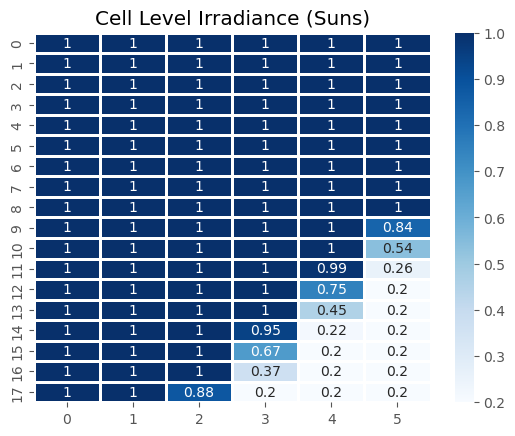

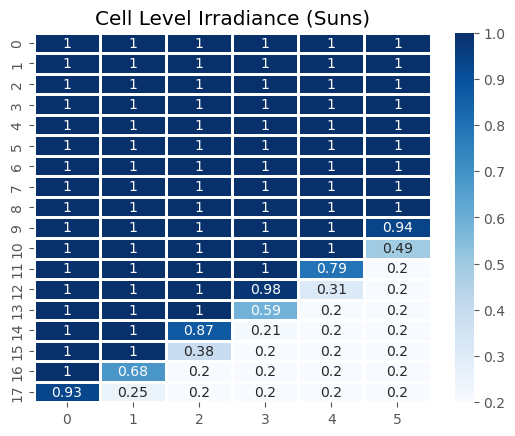

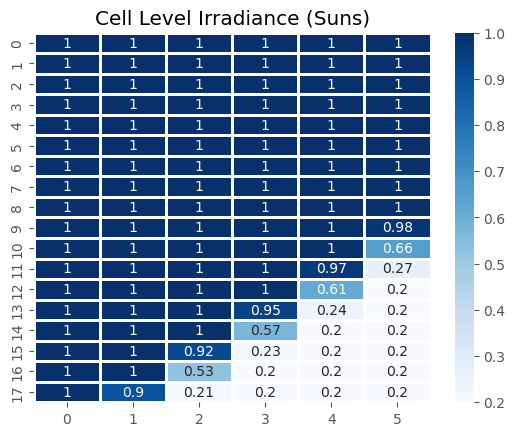

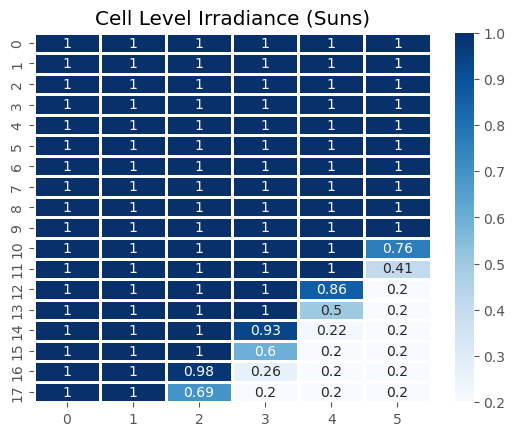

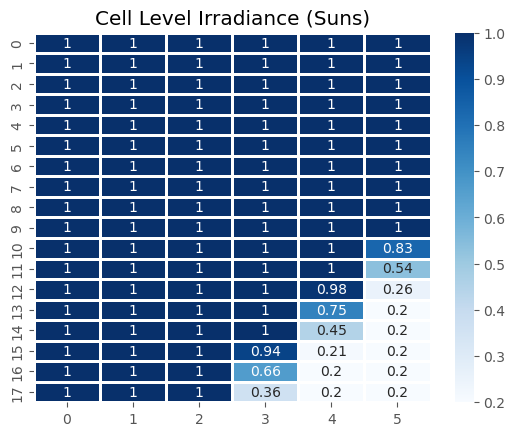

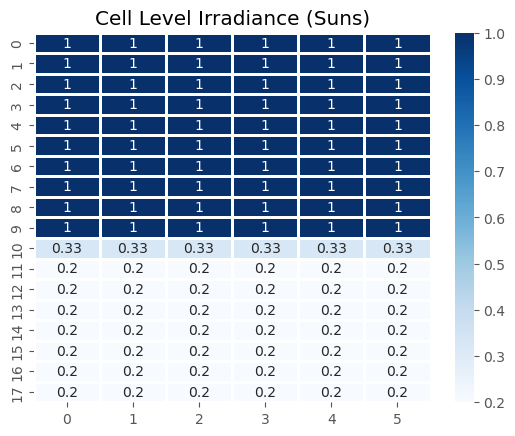

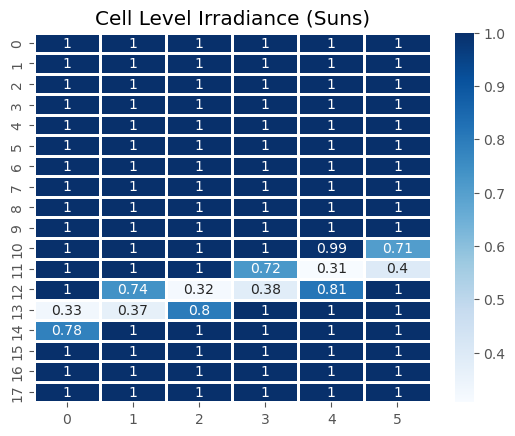

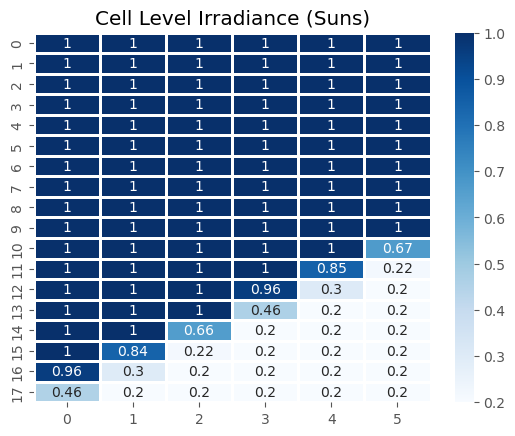

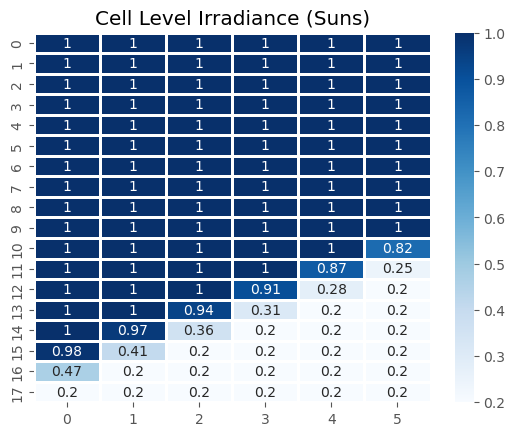

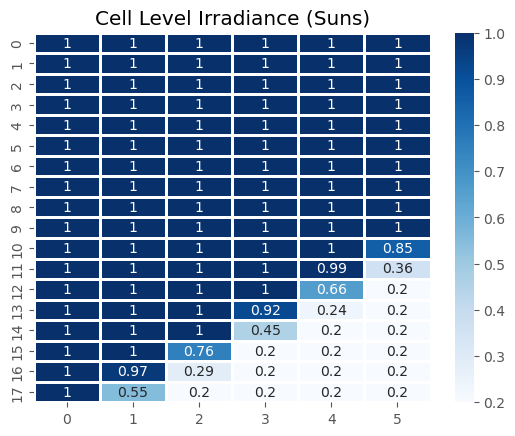

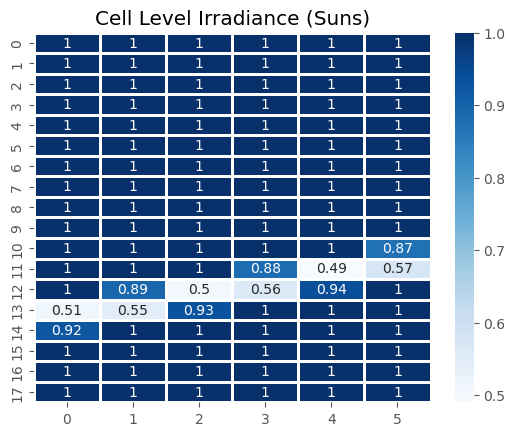

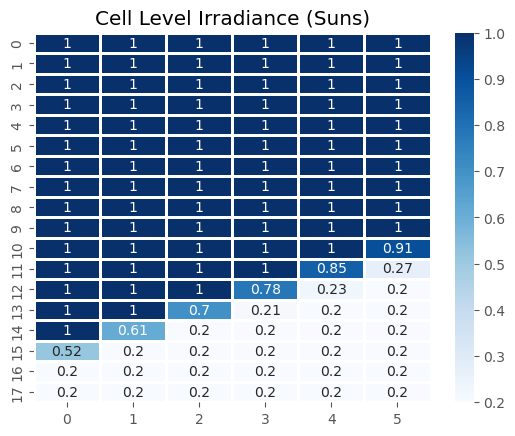

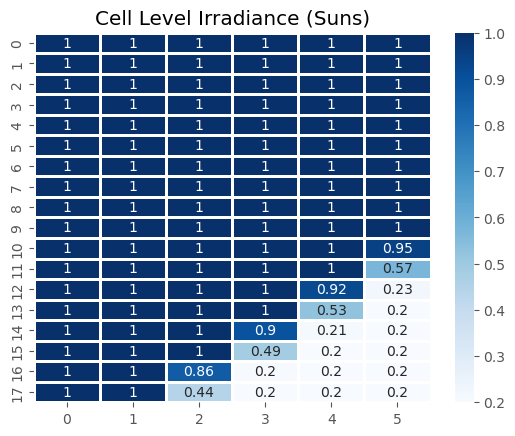

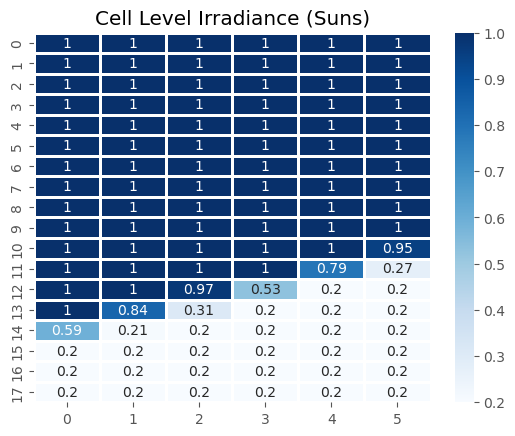

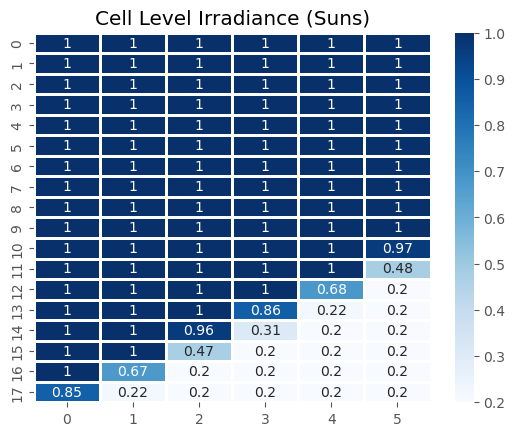

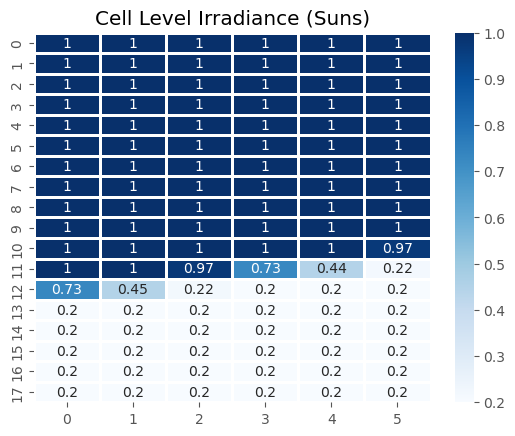

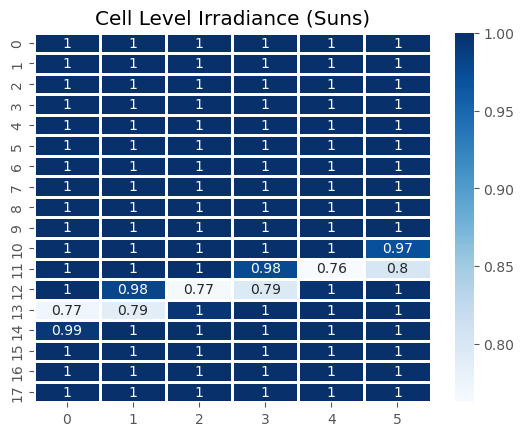

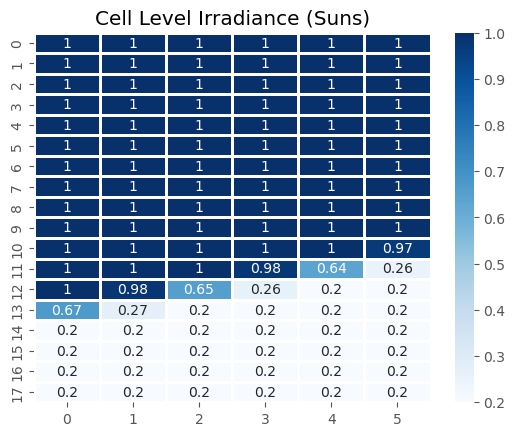

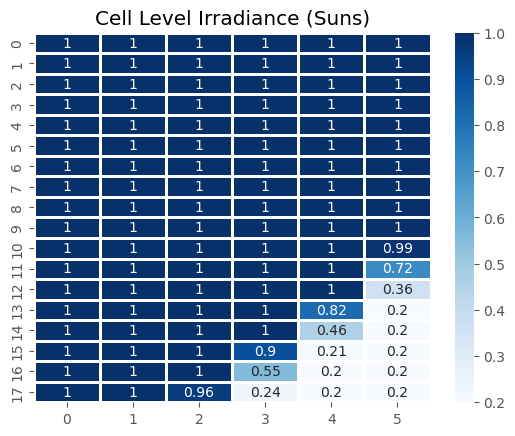

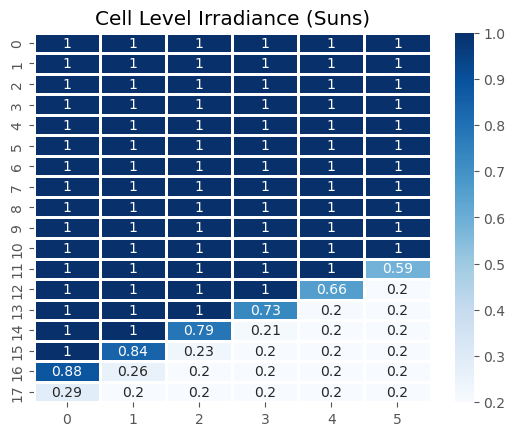

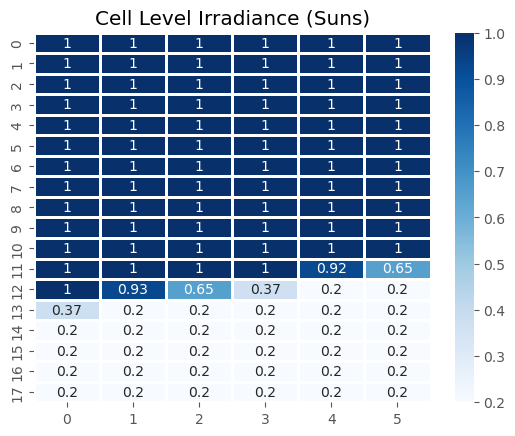

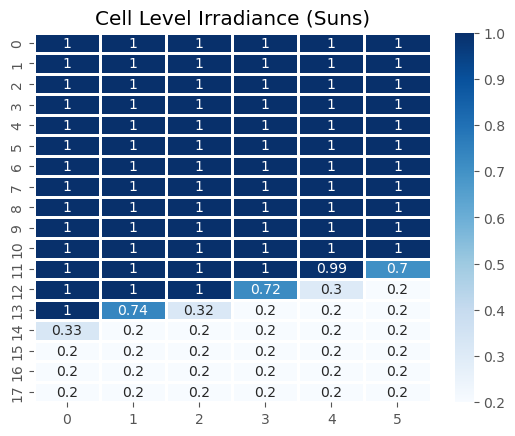

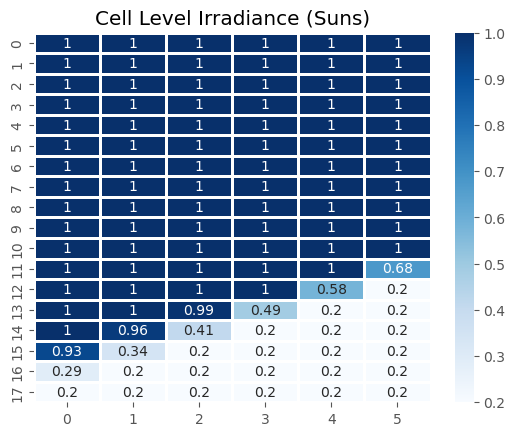

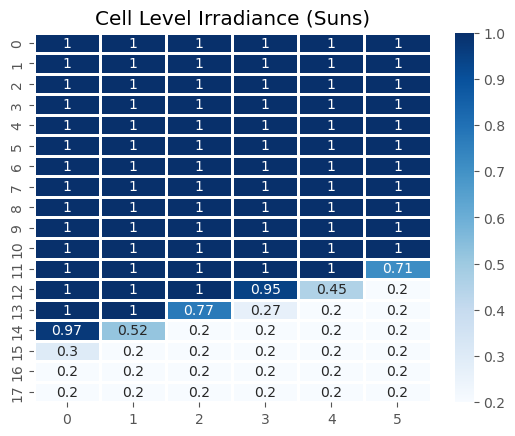

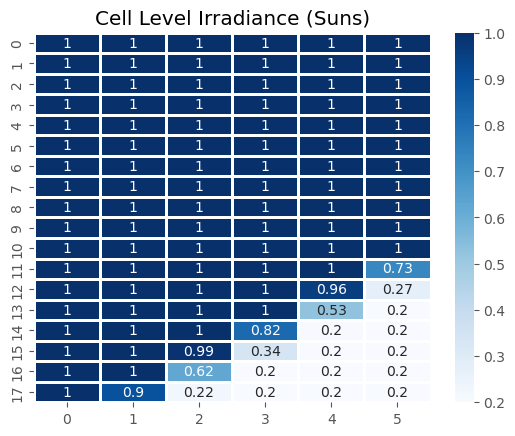

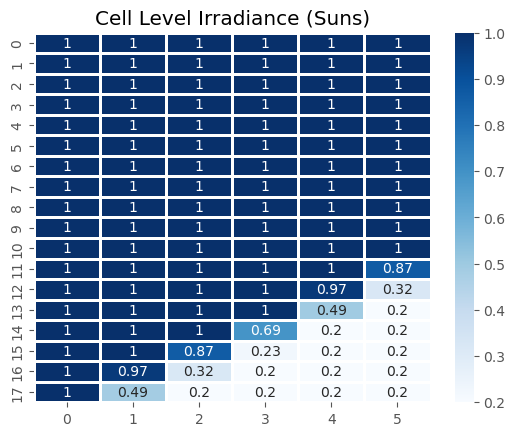

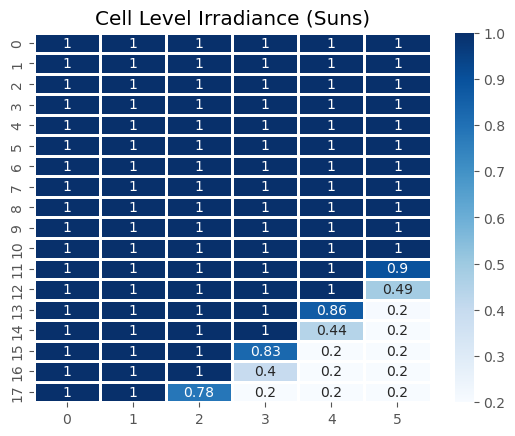

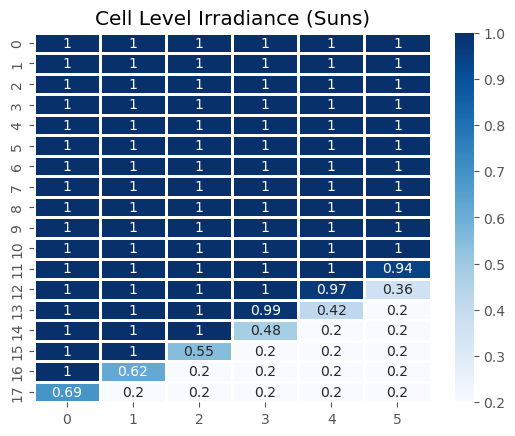

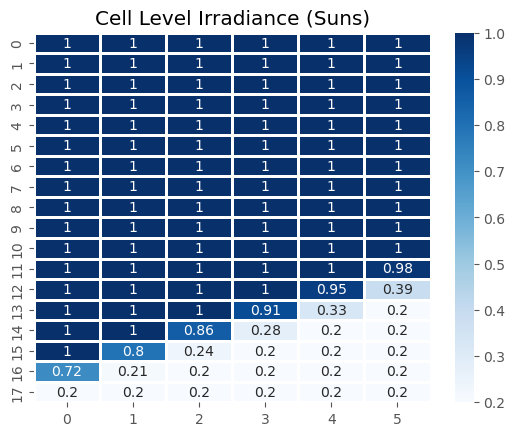

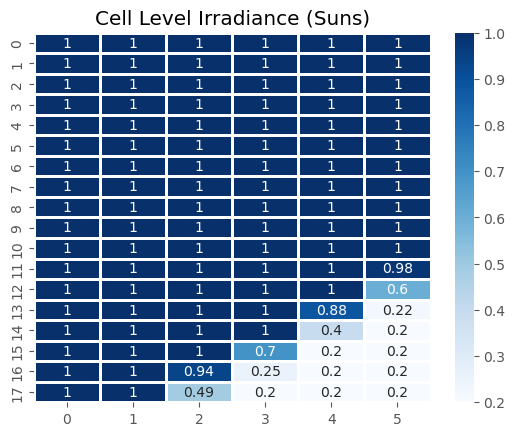

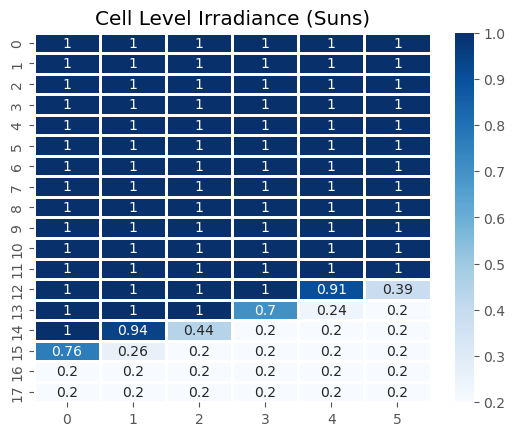

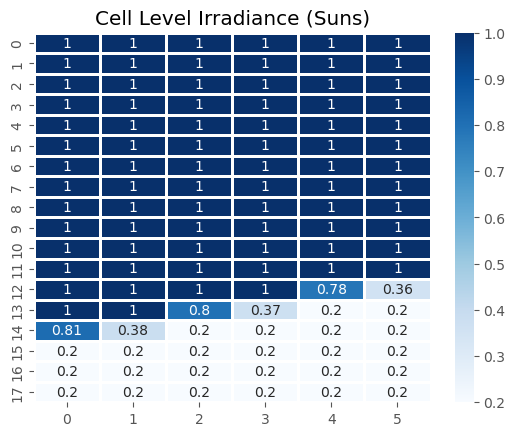

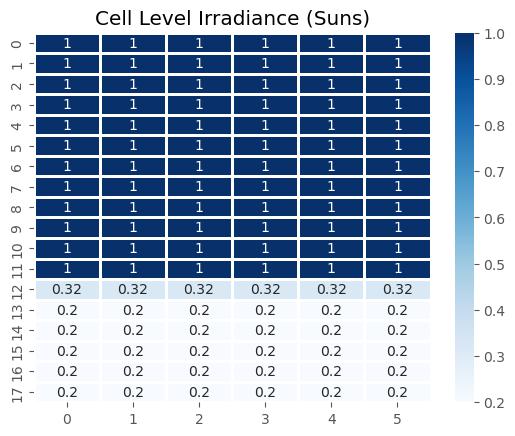

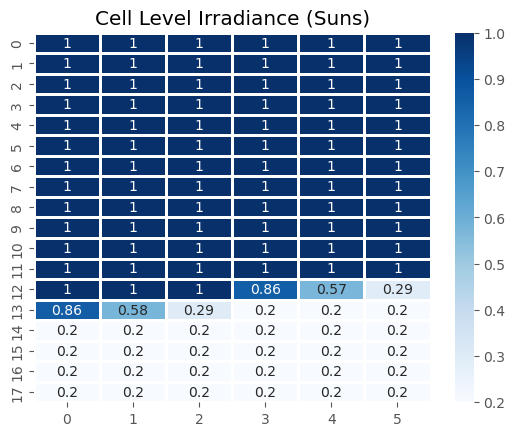

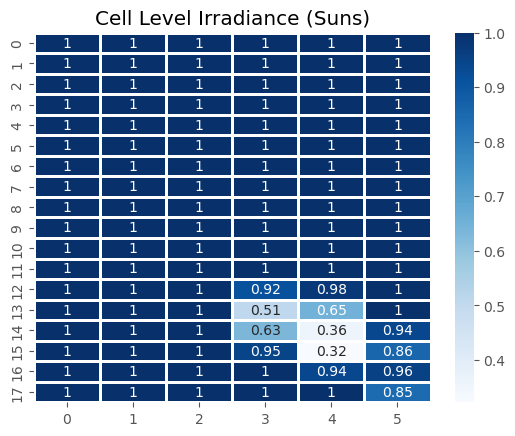

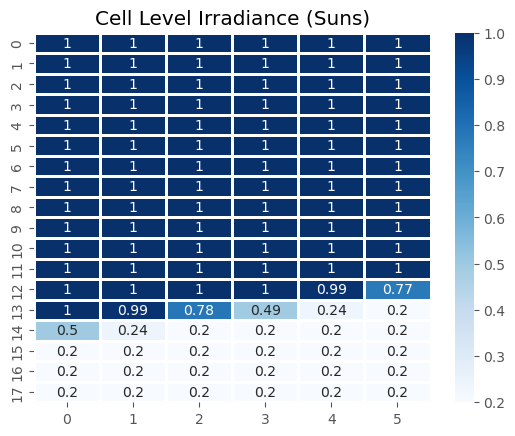

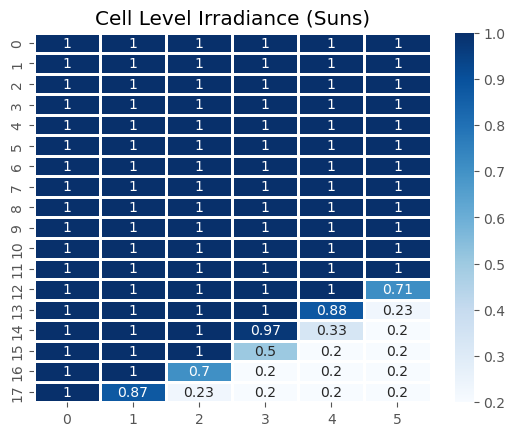

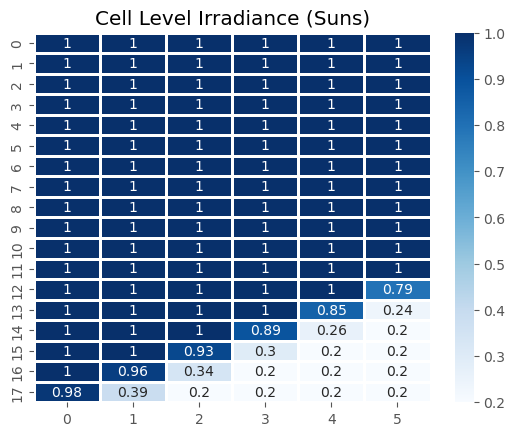

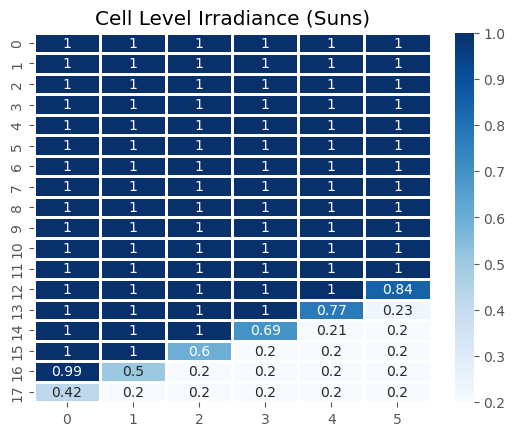

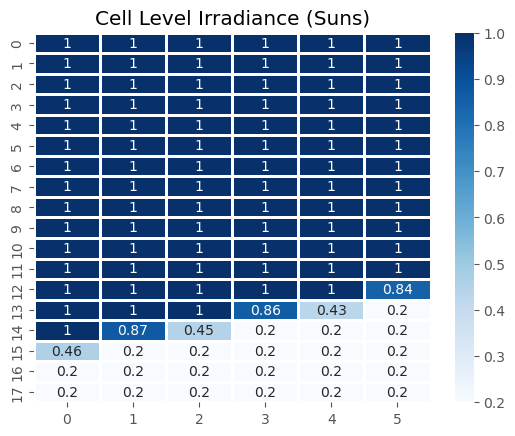

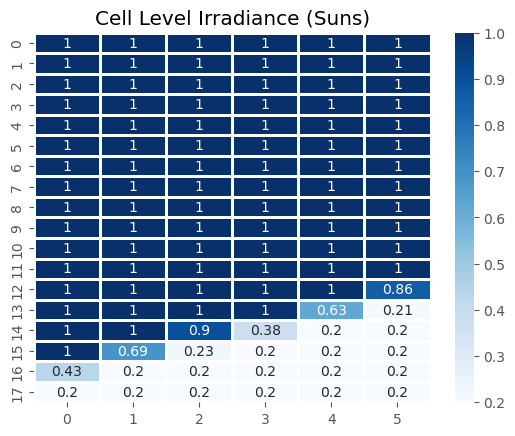

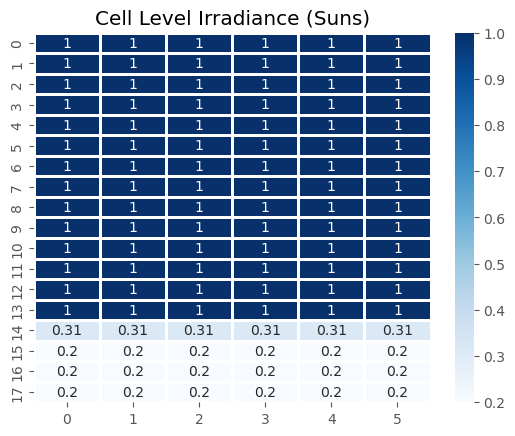

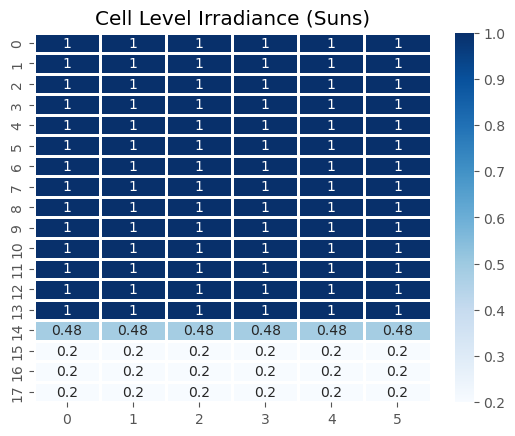

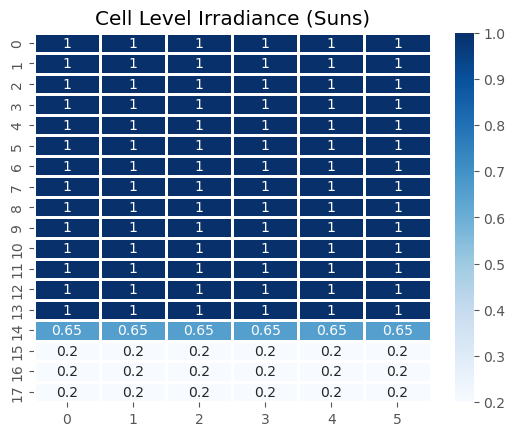

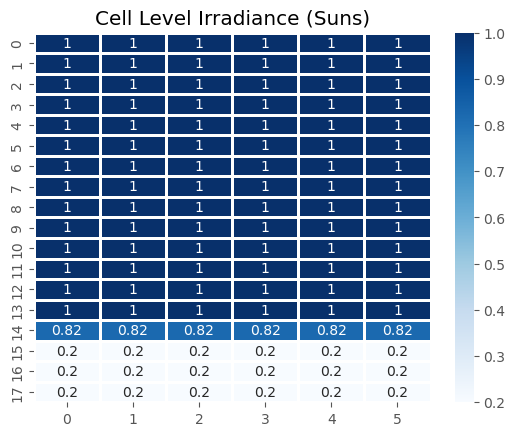

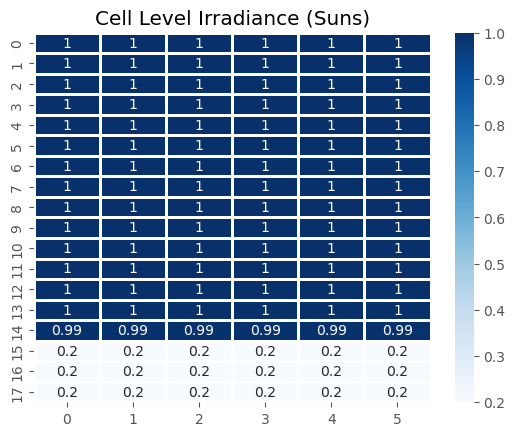

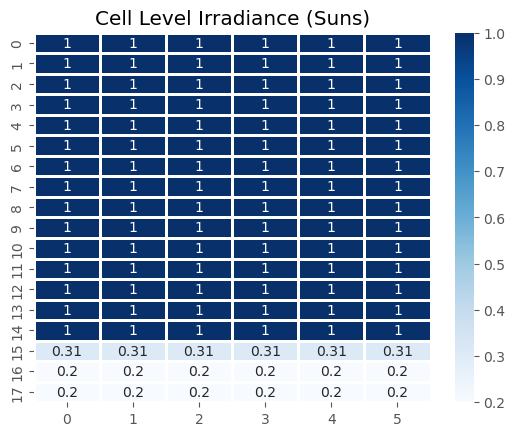

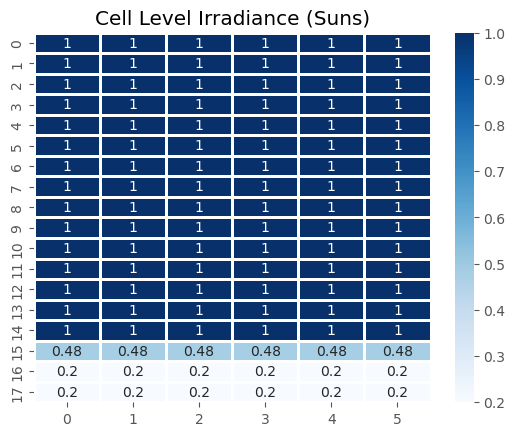

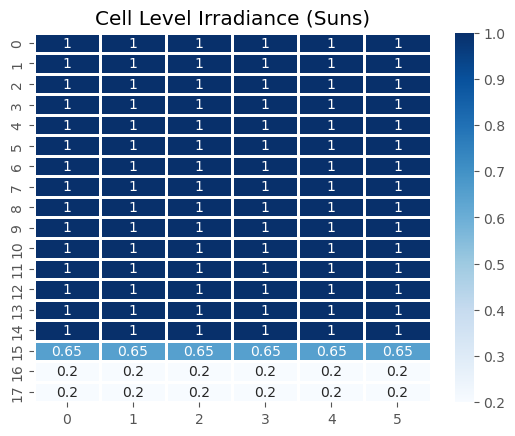

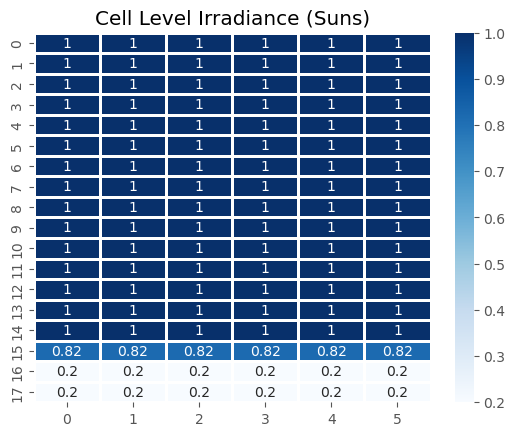

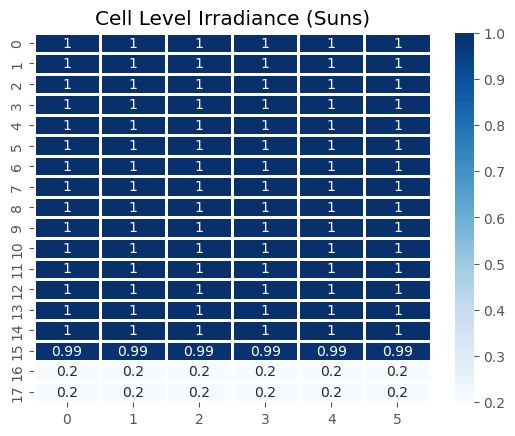

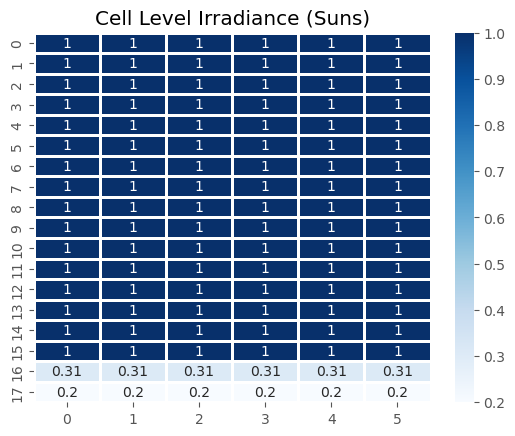

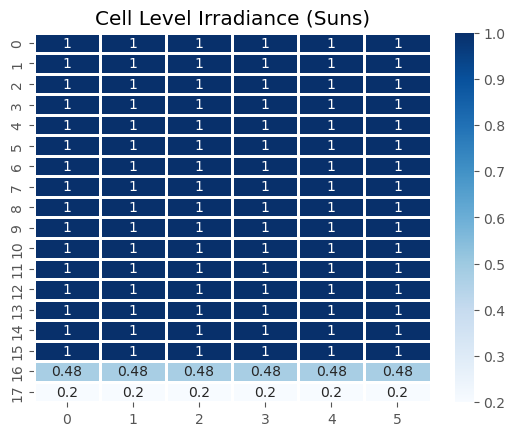

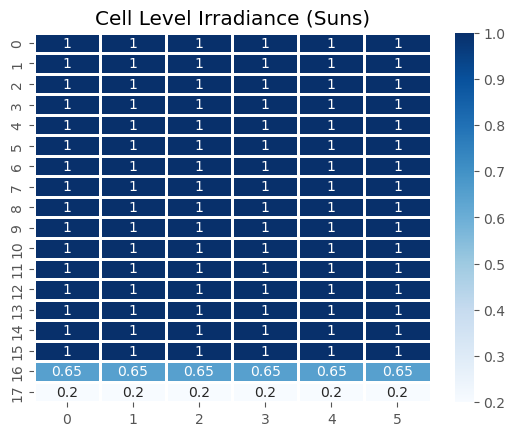

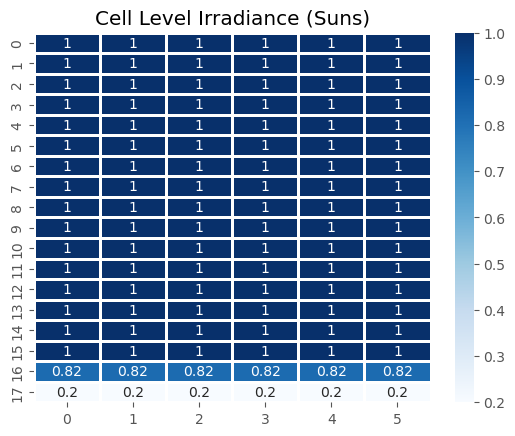

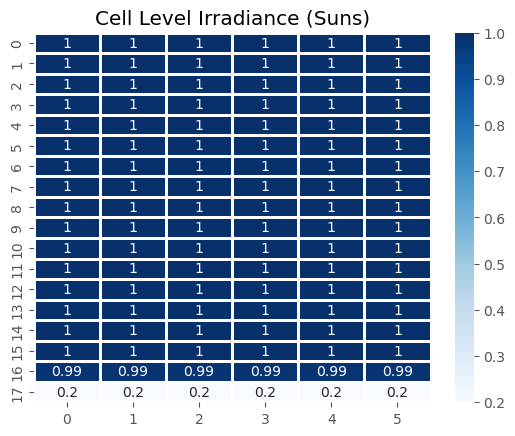

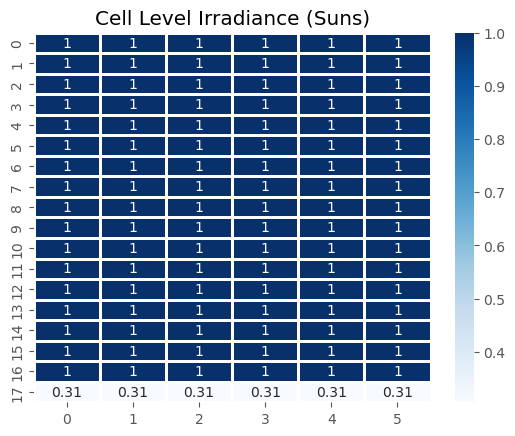

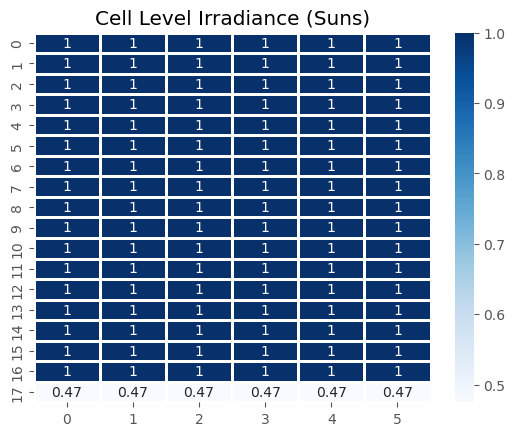

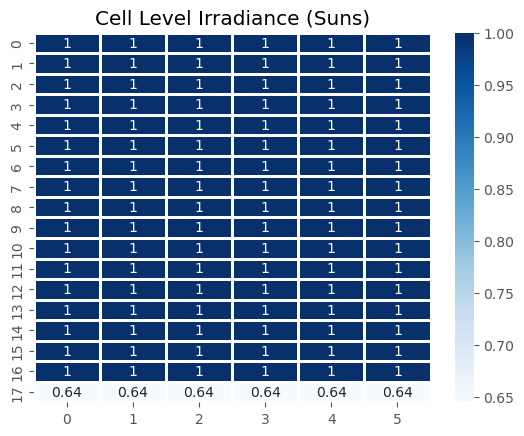

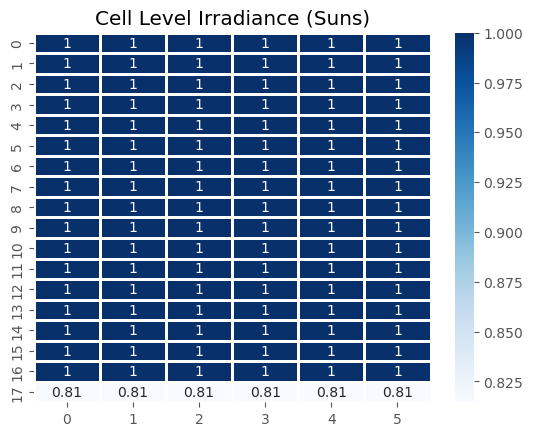

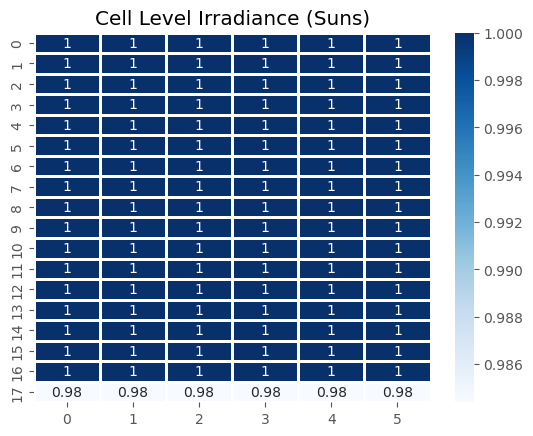

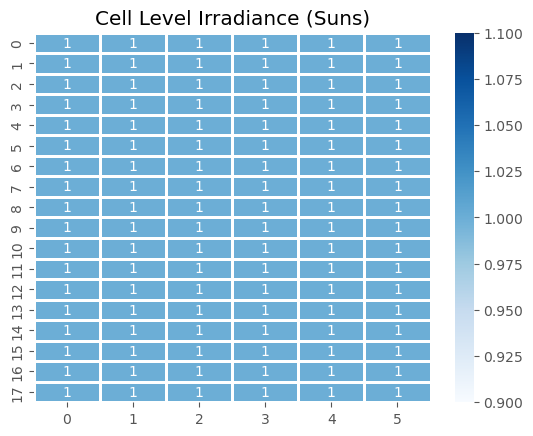

In [6]:
for mod in list(detailed_dict.keys()):
    plot_name = '_'.join([mod, 'Shade_arrays']) + '.pdf'
    with PdfPages(plot_name) as pdf:
        for idx_m in range(detailed_dict[mod]['Irr']['Module'].shape[0]):
            fig = plt.figure()
            ax = plt.axes()
            sns.heatmap(detailed_dict[mod]['Irr']['Module'][idx_m,:,:], annot=True, linewidths=2, cmap="Blues", 
                        cbar=True, ax=ax)
            ax.set_title('Cell Level Irradiance (Suns)')
            pdf.savefig(figure=fig)

### Plot system IV curves for all shade scenarios

This piece of code generates the IV curves for the PVsystem along with bypass diode activation flags. The plots are stored in a HTML file in cwd.

In [7]:
for mod in list(detailed_dict.keys()):
    plot_file = '_'.join([mod, 'System_IV_Curves']) + '.html'
    if os.path.isfile(plot_file):
        os.remove(plot_file)
    with open(plot_file, 'a') as f:
        for idx_m in range(detailed_dict[mod]['IV']['Sim']['Isys'].shape[0]):
            num_str = detailed_dict[mod]['IV']['Sim']['Bypass_activation'].shape[3]
            Pmax = detailed_dict[mod]['IV']['Sim']['Isys'][0,:].max()
            Vmax = detailed_dict[mod]['IV']['Sim']['Vsys'][0,:].max()
            fig = make_subplots(specs=[[{"secondary_y": True}]])
            fig.add_trace(go.Scatter(name="Unshaded", 
                         x=detailed_dict[mod]['IV']['Sim']['Vsys'][0,:], 
                         y=detailed_dict[mod]['IV']['Sim']['Isys'][0,:], line=dict(width=6)), secondary_y=False)
            fig.add_trace(go.Scatter(name="Shaded", 
                         x=detailed_dict[mod]['IV']['Sim']['Vsys'][idx_m,:], 
                         y=detailed_dict[mod]['IV']['Sim']['Isys'][idx_m,:], line=dict(width=6)), secondary_y=False)
            for idx_str in range(num_str):
                fig.add_trace(go.Scatter(name=' '.join(["BP Active String", str(idx_str+1)]), 
                                 x=detailed_dict[mod]['IV']['Sim']['Vsys'][idx_m,:], 
                                 y=detailed_dict[mod]['IV']['Sim']['Bypass_activation'][idx_m,0,0, idx_str,:], line=dict(width=6)), 
                              secondary_y=True)
                fig.update_yaxes(title_text='Current [A]', range=[0, Pmax+1], secondary_y=False)
                fig.update_yaxes(title_text='Bypass Diode Active', secondary_y=True)
                fig.update_xaxes(title_text='Voltage [V]', range=[-10, Vmax+1])
            fig.update_layout(
                template='ggplot2', 
                title_text=' '.join([mod, str(idx_m)]), 
                font_size=16)
            f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

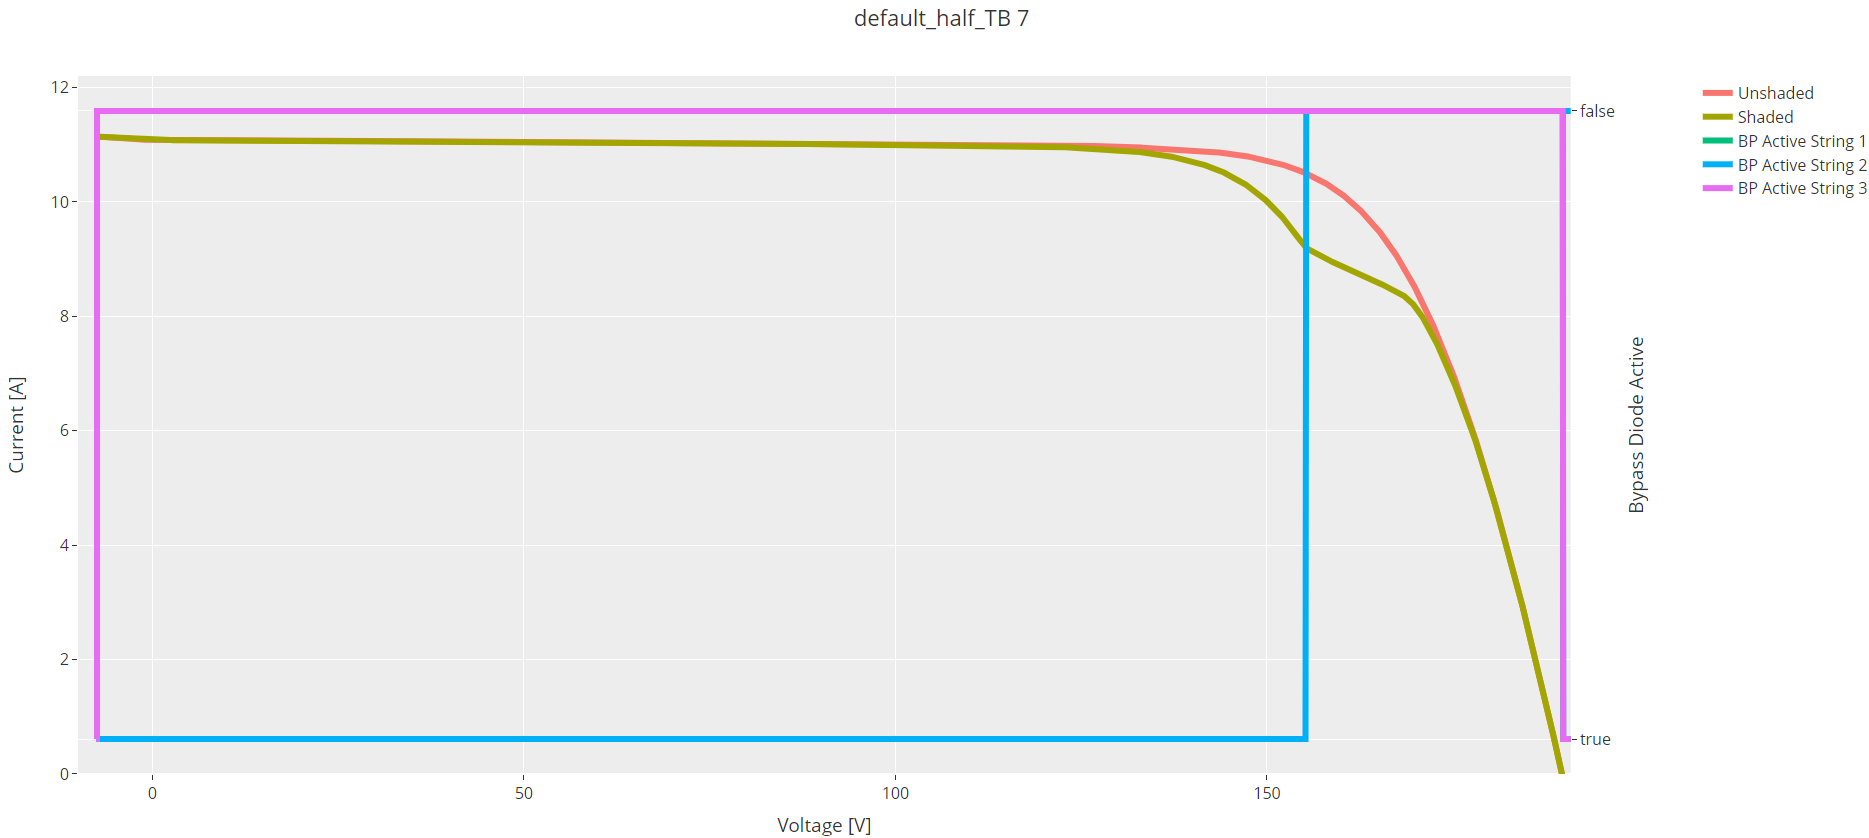

### Plot system PV curves for all shade scenarios

This piece of code generates the PV curves for the PVsystem along with bypass diode activation flags. The plots are stored in a HTML file in cwd.

In [8]:
for mod in list(detailed_dict.keys()):
    plot_file = '_'.join([mod, 'System_PV_Curves']) + '.html'
    if os.path.isfile(plot_file):
        os.remove(plot_file)
    with open(plot_file, 'a') as f:
        for idx_m in range(detailed_dict[mod]['IV']['Sim']['Isys'].shape[0]):
            num_str = detailed_dict[mod]['IV']['Sim']['Bypass_activation'].shape[3]
            Pmax = detailed_dict[mod]['IV']['Sim']['Psys'][0,:].max()
            Vmax = detailed_dict[mod]['IV']['Sim']['Vsys'][0,:].max()
            fig = make_subplots(specs=[[{"secondary_y": True}]])
            fig.add_trace(go.Scatter(name="Unshaded", 
                         x=detailed_dict[mod]['IV']['Sim']['Vsys'][0,:], 
                         y=detailed_dict[mod]['IV']['Sim']['Psys'][0,:], line=dict(width=6)), secondary_y=False)
            fig.add_trace(go.Scatter(name="Shaded", 
                         x=detailed_dict[mod]['IV']['Sim']['Vsys'][idx_m,:], 
                         y=detailed_dict[mod]['IV']['Sim']['Psys'][idx_m,:], line=dict(width=6)), secondary_y=False)
            for idx_str in range(num_str):
                fig.add_trace(go.Scatter(name=' '.join(["BP Active String", str(idx_str+1)]), 
                                 x=detailed_dict[mod]['IV']['Sim']['Vsys'][idx_m,:], 
                                 y=detailed_dict[mod]['IV']['Sim']['Bypass_activation'][idx_m,0,0, idx_str,:], line=dict(width=6)), 
                              secondary_y=True)
                fig.update_yaxes(title_text='Power [W]', range=[0, Pmax+1], secondary_y=False)
                fig.update_yaxes(title_text='Bypass Diode Active', secondary_y=True)
                fig.update_xaxes(title_text='Voltage [V]', range=[-10, Vmax+1])
            fig.update_layout(
                template='ggplot2', 
                title_text=' '.join([mod, str(idx_m)]), 
                font_size=16)
            f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

Plots can be generated similarly at the String or Module level by accessing the detailed dictionary. 